In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import ast
from scipy import stats
from scipy.optimize import curve_fit

In [2]:
#Ruta figures por capitulo
results_path = "/home/andres/Dropbox/Manuscrito_Thesis/Tesis_Andrés_López/figures/results/"

In [3]:
path = '../../results/halos_matched_disk_noduplicates.csv'
df = pd.read_csv(path)
df.head()

,subhalo_TNG50-1,halo_TNG50-1,Mvir_TNG50-1,halo_TNG50-3,Mvir_TNG50-3,has_disk
0,117251.0,3,3470.526367,3.0,3491.555176,1
1,143881.0,4,3142.989746,4.0,3239.478027,1
2,167393.0,5,1859.250610,5.0,1816.254150,1
3,184932.0,6,3027.909180,6.0,3017.573486,1
4,198183.0,7,2737.067871,7.0,2795.508057,1


In [4]:
#Contar el numero de halos con y sin disco
df['has_disk'].value_counts() 

has_disk
1    107
0     60
Name: count, dtype: int64

In [5]:
halos = df.copy()
halos.drop(columns=['halo_TNG50-1','subhalo_TNG50-1'], inplace=True)
#ordenar por el indice de TNG50-3
halos=halos.sort_values('halo_TNG50-3')
halos.reset_index(drop=True, inplace=True)
halos.head()

,Mvir_TNG50-1,halo_TNG50-3,Mvir_TNG50-3,has_disk
0,7466.339355,1.0,7462.923340,1
1,5243.999512,2.0,5181.124023,1
2,3470.526367,3.0,3491.555176,1
3,3142.989746,4.0,3239.478027,1
4,1859.250610,5.0,1816.254150,1


In [6]:
#leer archivo history
path = '../../results/halos_history.csv'
history = pd.read_csv(path)

history.head()

,halo_id,snap,z,epoch,Mdom,Mvir,Rvir
0,0,99,0.0,0,14868.514825,15079.097656,1082.225708
1,0,67,0.5,1,11816.643740,7356.986328,961.575439
2,1,50,1.0,2,6773.379776,4175.038086,831.712219
3,0,40,1.5,3,5495.054348,2296.211914,694.748718
4,0,33,2.0,4,6318.500934,1773.746460,643.600769


In [7]:
# Encontrar los índices donde snap == 99 (inicio de cada halo)
mask_z0 = history['snap'] == 99
start_idxs = history.index[mask_z0].tolist()
start_idxs.append(len(history))  # Añadir el final para el último halo

history_grouped = []
for i in range(len(start_idxs) - 1):
    group = history.iloc[start_idxs[i]:start_idxs[i+1]]
    history_grouped.append({
    'halo_id': np.array(group['halo_id']),
    'snap':   np.array(group['snap']),
    'z':      np.array(group['z']),
    'Mdom':   np.array(group['Mdom']),
    'Mvir':   np.array(group['Mvir']),
    'Rvir':   np.array(group['Rvir']),
})



In [8]:
history_accretion = pd.DataFrame(history_grouped)

In [9]:
# Filtrar history_accretion para mantener solo filas cuyo primer halo_id está en halos['halo_TNG50-3']
valid_ids = set(halos['halo_TNG50-3'])
mask = history_accretion['halo_id'].apply(lambda ids: ids[0] in valid_ids)
history_accretion = history_accretion[mask].reset_index(drop=True)

In [10]:
history_accretion['Mvir_ratio'] = history_accretion.apply(lambda row: np.array(row['Mvir']) / row['Mvir'][row['z'] == 0], axis=1)

In [11]:
#columna si tiene disco o no
history_accretion['has_disk'] = history_accretion['halo_id'].apply(lambda ids: halos.loc[halos['halo_TNG50-3'] == ids[0], 'has_disk'].values[0])


In [12]:
# Crear DataFrame con solo los resultados en z=0
z0_data = []

for i, row in history_accretion.iterrows():
    # Encontrar el índice donde z=0
    z_idx = np.where(row['z'] == 0)[0][0]
    
    z0_data.append({
        'halo_id': row['halo_id'][z_idx],
        'has_disk': row['has_disk'],
        'Mvir_z0': row['Mvir'][z_idx],
        'Mdom_z0': row['Mdom'][z_idx],
        'Rvir_z0': row['Rvir'][z_idx],
        'Mvir_Mdom_ratio': row['Mvir'][z_idx] / row['Mdom'][z_idx]
    })

z0_df = pd.DataFrame(z0_data)
z0_df.head()

,halo_id,has_disk,Mvir_z0,Mdom_z0,Rvir_z0,Mvir_Mdom_ratio
0,1,1,7462.923340,5440.241793,856.034973,1.371800
1,2,1,5181.124023,3813.406095,758.016785,1.358660
2,3,1,3491.555176,3095.055814,664.569702,1.128107
3,4,1,3239.478027,2720.432544,648.165588,1.190795
4,5,1,1816.254150,1798.465760,534.463318,1.009891


In [13]:
halo3_z0 = pd.read_csv('../../results/Halos_50_3_z0.dat', delim_whitespace=True, header=None, names=['X', 'Y', 'Z','Mvir','Rvir','Mdom','Npart'])
halo3_z0 = halo3_z0[halo3_z0['Mdom'] > 0]  # Filtrar halos con Mvir > 10^10 M_sun

/tmp/ipykernel_11722/2740427918.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  halo3_z0 = pd.read_csv('../../results/Halos_50_3_z0.dat', delim_whitespace=True, header=None, names=['X', 'Y', 'Z','Mvir','Rvir','Mdom','Npart'])


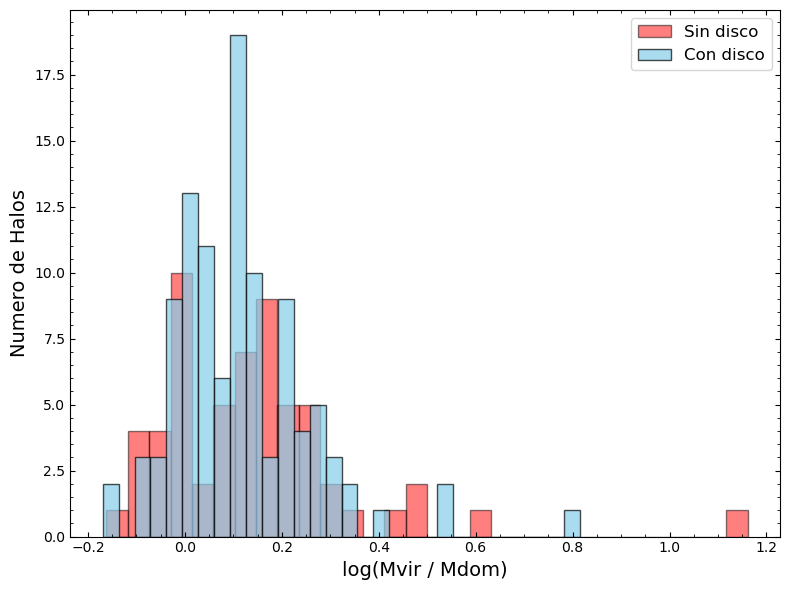

In [14]:
#histograma de Mvir/Mdom para halos con y sin disco
plt.figure(figsize=(8,6))
plt.hist(np.log10(z0_df[z0_df['has_disk'] == 0]['Mvir_Mdom_ratio']), bins=30, color='red', edgecolor='black', alpha=0.5, label='Sin disco')
#plt.hist(np.log10(z0_df[z0_df['has_disk'] == 0]['Mvir_Mdom_ratio']), bins=30, color='salmon', edgecolor='black', alpha=0.7, label='No disk')
plt.hist(np.log10(z0_df[z0_df['has_disk'] == 1]['Mvir_Mdom_ratio']), bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Con disco')
#plt.hist(np.log10(z0_df[z0_df['has_disk'] == 1]['Mvir_Mdom_ratio']), bins=30, color='skyblue', edgecolor='black', alpha=0.5, label='Disk')
plt.xlabel('log(Mvir / Mdom)', fontsize=14)
plt.ylabel('Numero de Halos', fontsize=14)
#plt.title('Distribución de Mvir / Mdom en halos con y sin disco', fontsize=16)
plt.legend(fontsize=12)
#mostrar los ticks secundarios entre los ticks principales
plt.minorticks_on()
#mostrar los ticks de arriba y la derecha hacia adentro
plt.tick_params(axis='both', which='both', top=True, right=True, direction='in')
plt.tight_layout()

plt.savefig(results_path + 'Mvir_Mdom_histogram_disk_nodisk_T3.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
from scipy.stats import ks_2samp

# Extraer las distribuciones de Mvir_Mdom_ratio para halos con y sin disco
mvir_mdom_disk = z0_df[z0_df['has_disk'] == 1]['Mvir_Mdom_ratio']
mvir_mdom_nodisk = z0_df[z0_df['has_disk'] == 0]['Mvir_Mdom_ratio']

# Realizar el test de Kolmogorov-Smirnov
ks_stat, p_value = ks_2samp(mvir_mdom_disk, mvir_mdom_nodisk)

print(f"Test de Kolmogorov-Smirnov:")
print(f"Estadístico KS: {ks_stat:.4f}")
print(f"p-valor: {p_value:.4f}")
if p_value < 0.05:
    print("Conclusión: Las distribuciones son significativamente diferentes (p < 0.05)")
else:
    print("Conclusión: No hay evidencia suficiente de que las distribuciones sean diferentes (p ≥ 0.05)")

Test de Kolmogorov-Smirnov:
Estadístico KS: 0.1648
p-valor: 0.2181
Conclusión: No hay evidencia suficiente de que las distribuciones sean diferentes (p ≥ 0.05)


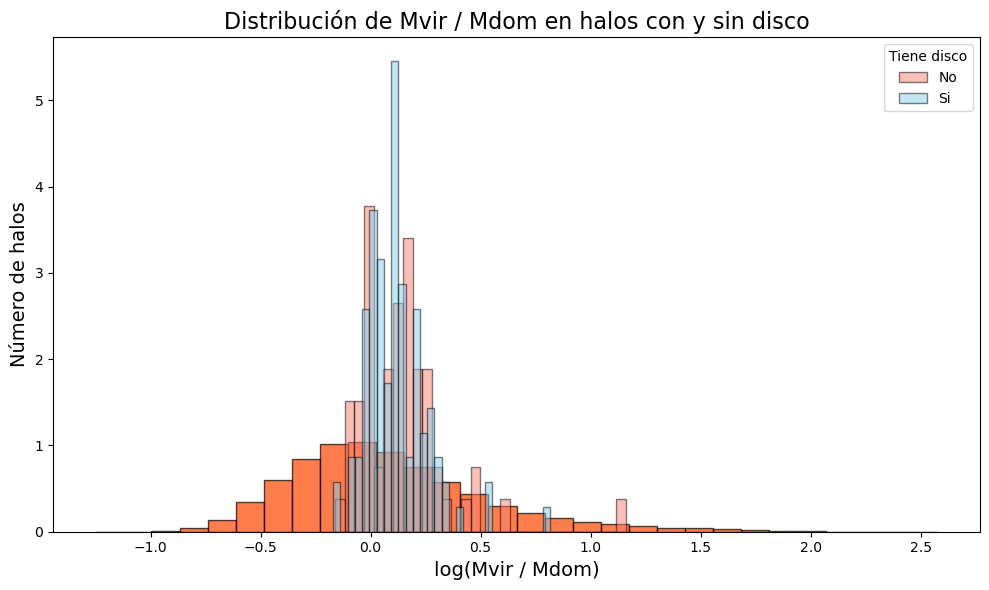

In [16]:
#histograma de Mvir/Mdom para halos con y sin disco
plt.figure(figsize=(10,6))

plt.hist(np.log10(halo3_z0['Mvir']/halo3_z0['Mdom']), bins=30, color='orangered', edgecolor='black',alpha=0.7,density=1)
plt.hist(np.log10(z0_df[z0_df['has_disk'] == 0]['Mvir_Mdom_ratio']), bins=30, color='salmon', edgecolor='black', alpha=0.5 ,density=1,label='No')
plt.hist(np.log10(z0_df[z0_df['has_disk'] == 1]['Mvir_Mdom_ratio']), bins=30, color='skyblue', edgecolor='black', alpha=0.5 ,density=1,label='Si')

plt.xlabel('log(Mvir / Mdom)', fontsize=14)
plt.ylabel('Número de halos', fontsize=14)
plt.title('Distribución de Mvir / Mdom en halos con y sin disco', fontsize=16)
plt.legend(title='Tiene disco')
plt.tight_layout()
#plt.savefig('Mvir_Mdom_histogram_disk_nodisk.png', dpi=300)
plt.show()

### Quitando outliers de la manera mas horrible posible

#### Halos con disco (naranja)

In [17]:
#quitar la de arriba
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (3.01 in row['z']) & (row['has_disk'] == 1)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][5])
        IDXS.append(i)

#Encontrar el indice con mayor masa
max_Mvir = max(Mvirs)
max_index = Mvirs.index(max_Mvir)
max_halo = IDXS[max_index]
print(f"El halo con mayor masa en z=3.01 es el índice {max_halo} con Mvir/Mvir0 = {max_Mvir}")

El halo con mayor masa en z=3.01 es el índice 164 con Mvir/Mvir0 = 0.6180555212628984


In [18]:
#Eliminar el halo con mayor masa en z=3.01
history_accretion = history_accretion.drop(index=max_halo).reset_index(drop=True)

In [19]:
#quitar la de mas abajo
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 1)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con menor masa
min_Mvir = min(Mvirs)
min_index = Mvirs.index(min_Mvir)
min_halo = IDXS[min_index]
print(f"El halo con menor masa en z=4.01 es el índice {min_halo} con Mvir/Mvir0 = {min_Mvir}")

El halo con menor masa en z=4.01 es el índice 67 con Mvir/Mvir0 = 0.0006967442738602725


In [20]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=min_halo).reset_index(drop=True)

In [21]:
#quitar la segunda de mas abajo
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 1)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con menor masa
min_Mvir = min(Mvirs)
min_index = Mvirs.index(min_Mvir)
min_halo = IDXS[min_index]
print(f"El halo con menor masa en z=4.01 es el índice {min_halo} con Mvir/Mvir0 = {min_Mvir}")

El halo con menor masa en z=4.01 es el índice 2 con Mvir/Mvir0 = 0.002689757184748481


In [22]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=min_halo).reset_index(drop=True)

#### Halos sin disco (azul)

In [23]:
#limpiar halos que no tienen disco outliers
#quitar la de mas arriba
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 0)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con mayor masa
max_Mvir = max(Mvirs)
max_index = Mvirs.index(max_Mvir)
max_halo = IDXS[max_index]
print(f"El halo con mayor masa en z=4.01 es el índice {max_halo} con Mvir/Mvir0 = {max_Mvir}")

El halo con mayor masa en z=4.01 es el índice 161 con Mvir/Mvir0 = 0.36986303379475655


In [24]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=max_halo).reset_index(drop=True)

In [25]:
#limpiar halos que no tienen disco outliers
#quitar la segunda de mas arriba
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 0)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con mayor masa
max_Mvir = max(Mvirs)
max_index = Mvirs.index(max_Mvir)
max_halo = IDXS[max_index]
print(f"El halo con mayor masa en z=4.01 es el índice {max_halo} con Mvir/Mvir0 = {max_Mvir}")

El halo con mayor masa en z=4.01 es el índice 147 con Mvir/Mvir0 = 0.32344148385448007


In [26]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=max_halo).reset_index(drop=True)

In [27]:
#limpiar halos que no tienen disco outliers
#quitar la de mas abajo
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 0)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con menor masa
min_Mvir = min(Mvirs)
min_index = Mvirs.index(min_Mvir)
min_halo = IDXS[min_index]
print(f"El halo con menor masa en z=4.01 es el índice {min_halo} con Mvir/Mvir0 = {min_Mvir}")

El halo con menor masa en z=4.01 es el índice 127 con Mvir/Mvir0 = 0.0004035814015203559


In [28]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=min_halo).reset_index(drop=True)

In [29]:
history_accretion['Mdom/Mdom0'] = history_accretion.apply(lambda row: np.log10(row['Mdom']/row['Mdom'][row['z'] == 0]), axis=1)

In [30]:
# # Separar halos según si Mdom/Mdom0 aumenta o siempre disminuye
# halos_Mdomup = []
# halos_Mdomdown = []

# for i, row in history_accretion.iterrows():
#     # Calcular Mdom/Mdom0 para cada z
#     mdom_ratio = row['Mdom'] / row['Mdom'][row['z'] == 0]
    
#     # Verificar si algún valor es mayor a 1 (excluyendo z=0 que siempre es 1)
#     if np.any(mdom_ratio[1:] > 1):
#         halos_Mdomup.append(i)
#     else:
#         halos_Mdomdown.append(i)

# # Crear los DataFrames
# halos_Mdomup = history_accretion.loc[halos_Mdomup].reset_index(drop=True)
# halos_Mdomdown = history_accretion.loc[halos_Mdomdown].reset_index(drop=True)

# print(f"Halos con Mdom/Mdom0 > 1 en algún z: {len(halos_Mdomup)}")
# print(f"Halos con Mdom/Mdom0 ≤ 1 en algún z: {len(halos_Mdomdown)}")

## Tipos de evolucion masa dominio

In [31]:
# Separar halos según la pendiente del ajuste de Mdom vs z
halos_Mdomup_idxs = []
halos_Mdomdown_idxs = []

def linear_fit(z, a, b):
    """Función lineal: y = a*z + b"""
    return a*z + b

for i, row in history_accretion.iterrows():
    z_vals = np.array(row['z'])
    mdom_vals = np.array(row['Mdom'])
    
    # Normalizar por Mdom en z=0
    idx_0 = np.where(z_vals == 0)[0]
    if len(idx_0) > 0 and len(z_vals) >= 3:  # Necesitamos al menos 3 puntos para ajustar
        mdom_0 = mdom_vals[idx_0[0]]
        if mdom_0 > 0:
            mdom_ratio = mdom_vals / mdom_0
            log_mdom = np.log10(mdom_ratio)
            
            # Ajuste lineal: log(Mdom/Mdom0) = a*z + b
            try:
                popt, _ = curve_fit(linear_fit, z_vals, log_mdom)
                slope = popt[0]  # pendiente 'a'
                
                if slope > 0:
                    halos_Mdomup_idxs.append(i)
                else:
                    halos_Mdomdown_idxs.append(i)
            except:
                # Si el ajuste falla, no clasificar este halo
                pass

# Crear los DataFrames
halos_Mdomup = history_accretion.loc[halos_Mdomup_idxs].reset_index(drop=True)
halos_Mdomdown = history_accretion.loc[halos_Mdomdown_idxs].reset_index(drop=True)

print(f"Clasificación por pendiente de Mdom(z):")
print(f"Halos con pendiente positiva (Tipo 1 - acreción): {len(halos_Mdomup)}")
print(f"Halos con pendiente negativa (Tipo 2 - pérdida): {len(halos_Mdomdown)}")

Clasificación por pendiente de Mdom(z):
Halos con pendiente positiva (Tipo 1 - acreción): 40
Halos con pendiente negativa (Tipo 2 - pérdida): 119


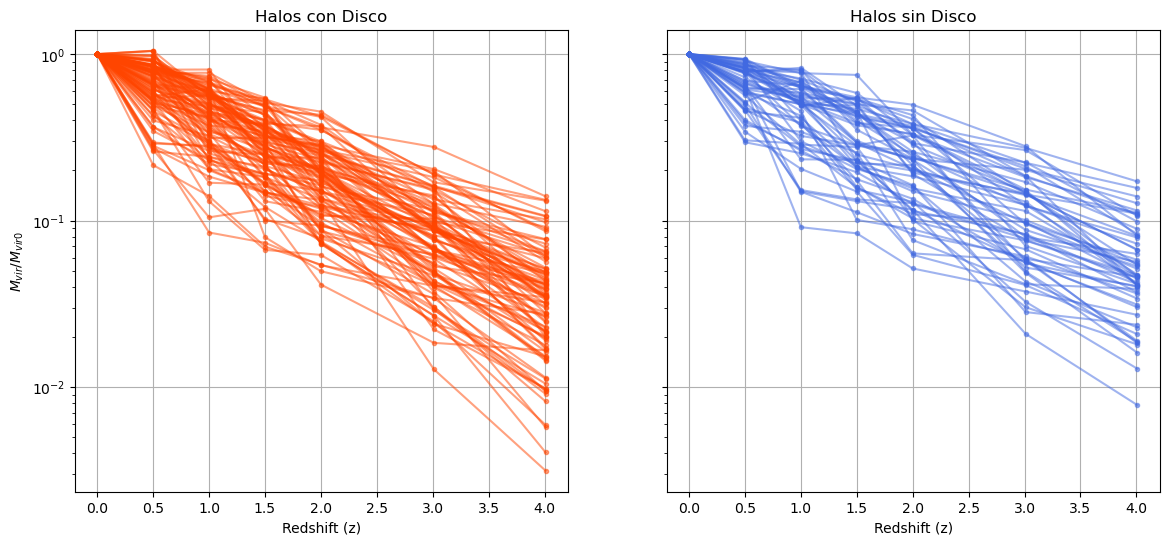

In [32]:
#grafica de Mvir vs z para halos con y sin disco
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Halos con disco
mask_disk = history_accretion['has_disk'] == 1
for i, row in history_accretion[mask_disk].iterrows():
    #dividiendo por la masa en z=0
    axs[0].plot(row['z'], row['Mvir']/row['Mvir'][row['z']==0], marker='.', linestyle='-', alpha=0.5, color='orangered')
axs[0].set_title('Halos con Disco')
axs[0].set_xlabel('Redshift (z)')
axs[0].set_ylabel('$M_{vir}$/$M_{vir0}$')
axs[0].set_yscale('log')
axs[0].grid(True)

# Halos sin disco
mask_nodisk = history_accretion['has_disk'] == 0
for i, row in history_accretion[mask_nodisk].iterrows():
    axs[1].plot(row['z'], row['Mvir']/row['Mvir'][row['z']==0], marker='.', linestyle='-', alpha=0.5, color='royalblue')
axs[1].set_title('Halos sin Disco')
axs[1].set_xlabel('Redshift (z)')
axs[1].set_yscale('log')
axs[1].grid(True)

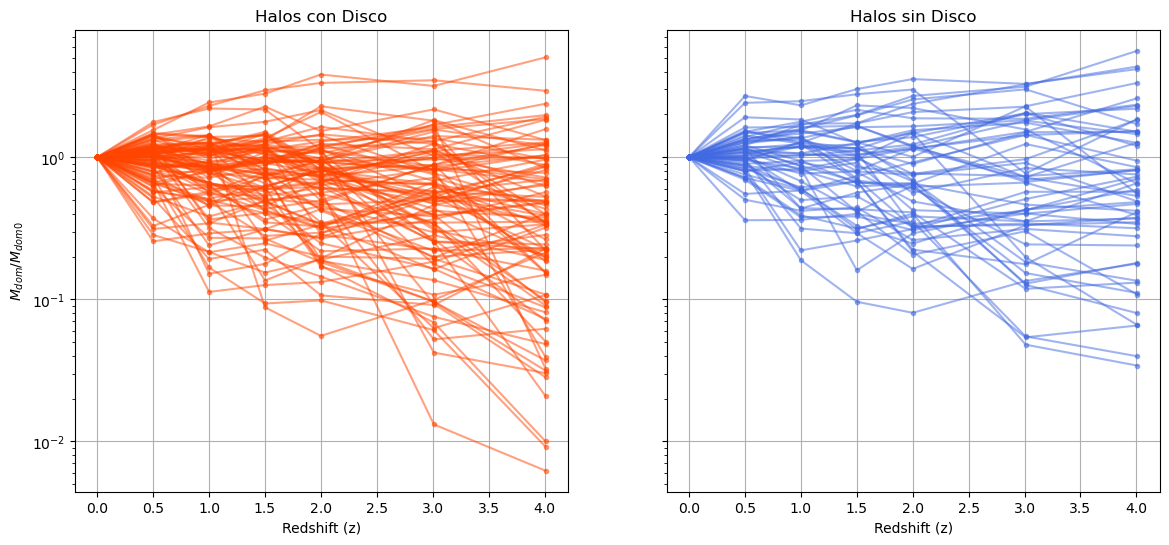

In [33]:
#grafica de Mdom vs z para halos con y sin disco
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Halos con disco
mask_disk = history_accretion['has_disk'] == True
for i, row in history_accretion[mask_disk].iterrows():
    #dividiendo por la masa en z=0
    axs[0].plot(row['z'], row['Mdom']/row['Mdom'][row['z'] == 0], marker='.', linestyle='-', alpha=0.5, color='orangered')
    
axs[0].set_title('Halos con Disco')
axs[0].set_xlabel('Redshift (z)')
axs[0].set_ylabel('$M_{dom}$/$M_{dom0}$')
axs[0].set_yscale('log')
axs[0].grid(True)

# Halos sin disco
mask_nodisk = history_accretion['has_disk'] == False
for i, row in history_accretion[mask_nodisk].iterrows():
    axs[1].plot(row['z'], row['Mdom']/row['Mdom'][row['z'] == 0], marker='.', linestyle='-', alpha=0.5, color='royalblue')
axs[1].set_title('Halos sin Disco')
axs[1].set_xlabel('Redshift (z)')
axs[1].set_yscale('log')
axs[1].grid(True)

In [34]:
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]


### Mdom

In [35]:
# fig, ax = plt.subplots(figsize=(10,6))

# # Funcion para graficar grupos
# def plot_group(halos, color, label):
#     # Historias individuales
#     for i, row in halos.iterrows():
#         z = np.array(row['z'])

#         m_vir_dom = np.array(row['Mvir']/row['Mdom'])
#         ax.plot(z, m_vir_dom, color=color, alpha=0.1)

#     # Mediana en cada z
#     m_vir_dom_by_z = {}
#     for i, row in halos.iterrows():
#         for zz, m in zip(row['z'], row['Mvir']/row['Mdom']):
#             if zz not in m_vir_dom_by_z:
#                 m_vir_dom_by_z[zz] = []
#             m_vir_dom_by_z[zz].append(m)

#     z_vals = sorted(m_vir_dom_by_z.keys())
#     m_vir_dom_median = [np.median(m_vir_dom_by_z[zz]) for zz in z_vals]

#     # Curva de la mediana
#     ax.plot(z_vals, m_vir_dom_median, color=color, lw=2, label=label)

# # Halos con disco
# halos_disk = history_accretion[history_accretion['has_disk'] == 1]
# plot_group(halos_disk, color='orangered', label='Con disco')

# # Halos sin disco
# halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
# plot_group(halos_nodisk, color='royalblue', label='Sin disco')

# ax.set_xlabel("z")
# ax.set_ylabel(r"$M_{\rm vir}/M_{\rm dom}$")
# ax.legend()
# ax.set_yscale('log')
# ax.grid(True)

### Mvir

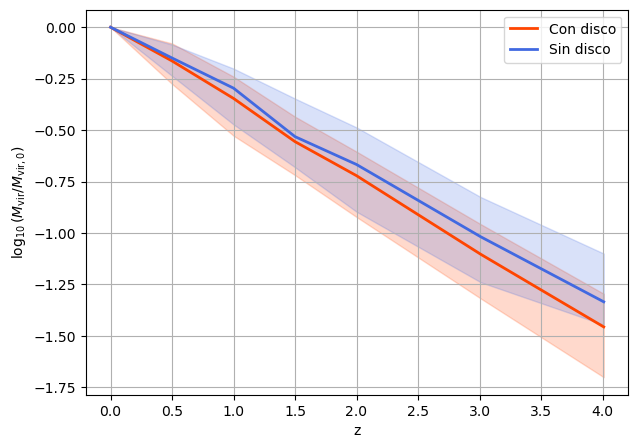

In [36]:
fig, ax = plt.subplots(figsize=(7,5))

# Función para graficar grupos con dispersión
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir = np.array(row['Mvir']/row['Mvir'][row['z'] == 0])

    # Agrupar por z
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = sorted(mvir_by_z.keys())
    mvir_median = [np.median(mvir_by_z[zz]) for zz in z_vals]
    mvir_q25    = [np.percentile(mvir_by_z[zz], 25) for zz in z_vals]
    mvir_q75    = [np.percentile(mvir_by_z[zz], 75) for zz in z_vals]

    # Mediana
    ax.plot(z_vals, np.log10(mvir_median), color=color, lw=2, label=label)
    # Banda de dispersión
    ax.fill_between(z_vals, np.log10(mvir_q25), np.log10(mvir_q75),
                    color=color, alpha=0.2)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z")
ax.set_ylabel(r"$\log_{10}(M_{\rm vir}/M_{\rm vir,0})$")
ax.legend()
ax.grid(True)
plt.show()


### Mdom

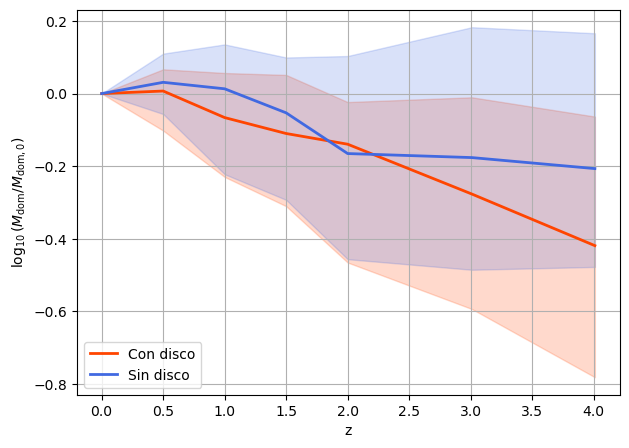

In [37]:
fig, ax = plt.subplots(figsize=(7,5))

# Función para graficar
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mdom = np.array(row['Mdom']/row['Mdom'][row['z'] == 0])

    # Agrupar por z
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = sorted(mdom_by_z.keys())
    mdom_median = [np.median(mdom_by_z[zz]) for zz in z_vals]
    mdom_q25    = [np.percentile(mdom_by_z[zz], 25) for zz in z_vals]
    mdom_q75    = [np.percentile(mdom_by_z[zz], 75) for zz in z_vals]

    # Mediana
    ax.plot(z_vals, np.log10(mdom_median), color=color, lw=2, label=label)
    # Banda de dispersión
    ax.fill_between(z_vals, np.log10(mdom_q25), np.log10(mdom_q75),
                    color=color, alpha=0.2)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z")
ax.set_ylabel(r"$\log_{10}(M_{\rm dom}/M_{\rm dom,0})$")
ax.legend()
ax.grid(True)
plt.show()


### Mvir/Mdom

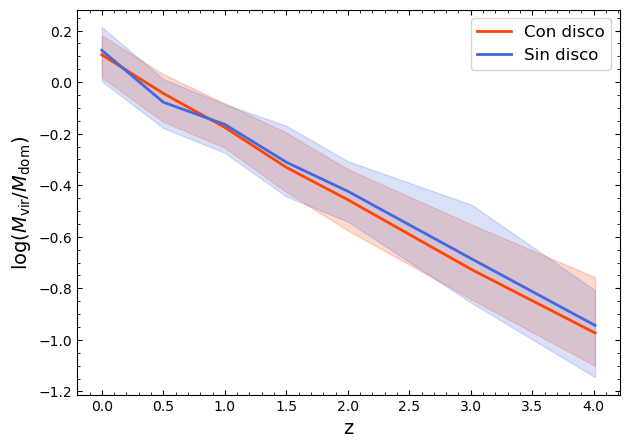

In [38]:
#mvir/mdom vs z con dispersión para halos con y sin disco
fig, ax = plt.subplots(figsize=(7,5))

# Función para graficar grupos con dispersión
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir_mdom = np.array(row['Mvir']/row['Mdom'])

    # Agrupar por z
    mvir_mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']/row['Mdom']):
            if zz not in mvir_mdom_by_z:
                mvir_mdom_by_z[zz] = []
            mvir_mdom_by_z[zz].append(m)

    z_vals = sorted(mvir_mdom_by_z.keys())
    mvir_mdom_median = [np.median(mvir_mdom_by_z[zz]) for zz in z_vals]
    mvir_mdom_q25    = [np.percentile(mvir_mdom_by_z[zz], 25) for zz in z_vals]
    mvir_mdom_q75    = [np.percentile(mvir_mdom_by_z[zz], 75) for zz in z_vals]

    # Mediana
    ax.plot(z_vals, np.log10(mvir_mdom_median), color=color, lw=2, label=label)
    # Banda de dispersión
    ax.fill_between(z_vals, np.log10(mvir_mdom_q25), np.log10(mvir_mdom_q75),
                    color=color, alpha=0.2)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z", fontsize=14)
ax.set_ylabel(r"$\log(M_{\rm vir}/M_{\rm dom})$", fontsize=14)
#mostrar los ticks secundarios entre los ticks principales
plt.minorticks_on()
#mostrar los ticks de arriba y la derecha hacia adentro
plt.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend(fontsize=12)
#ax.grid(True)
plt.savefig(results_path + 'Mvir_Mdom_vs_z_disk_nodisk_T3.png', dpi=300, bbox_inches='tight')
plt.show()

### Mvir

In [39]:
#fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

def plot_group(ax, halos, color, title, outlier_indices=[]):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir = np.array(row['Mvir'])/row['Mvir'][row['z'] == 0]
        ax.plot(z, np.log10(mvir), color=color, alpha=0.1)
        if i in outlier_indices:
            ax.plot(z, np.log10(mvir), color='red', alpha=0.7)

    # Agrupar por z
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    mvir_q25    = np.array([np.percentile(mvir_by_z[zz], 25) for zz in z_vals])
    mvir_q75    = np.array([np.percentile(mvir_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(z_vals, np.log10(mvir_median),
                yerr=[np.log10(mvir_median)-np.log10(mvir_q25),
                      np.log10(mvir_q75)-np.log10(mvir_median)],
                fmt='o', color='black', ecolor='black', capsize=3,
                label='Mediana ± IQR')

    #ax.set_title(title)
    ax.set_xlabel("z")
    ax.grid(True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
#plot_group(axs[0], halos_disk, color='orangered', title='Halos con disco')
#plot_group(axs[0], halos_disk, color='orangered', title='Halos with disk')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
#plot_group(axs[1], halos_nodisk, color='royalblue', title='Halos sin disco')
#plot_group(axs[1], halos_nodisk, color='royalblue', title='Halos without disk')

# axs[0].set_ylabel(r"$\log(M_{\rm vir}/M_{\rm vir,0})$")
# axs[0].legend(['Disk'], markerscale = 3)
# axs[1].legend(['No disk'], markerscale = 3)

# plt.tight_layout()
# plt.show()



Con disco:
log(Mvir/Mvir0) = (-0.3668 ± 0.0033, rel 0.90%) * z + (0.0087 ± 0.0072, rel 81.96%)
R² = 0.9996

Sin disco:
log(Mvir/Mvir0) = (-0.3380 ± 0.0067, rel 1.97%) * z + (0.0092 ± 0.0144, rel 156.29%)
R² = 0.9981



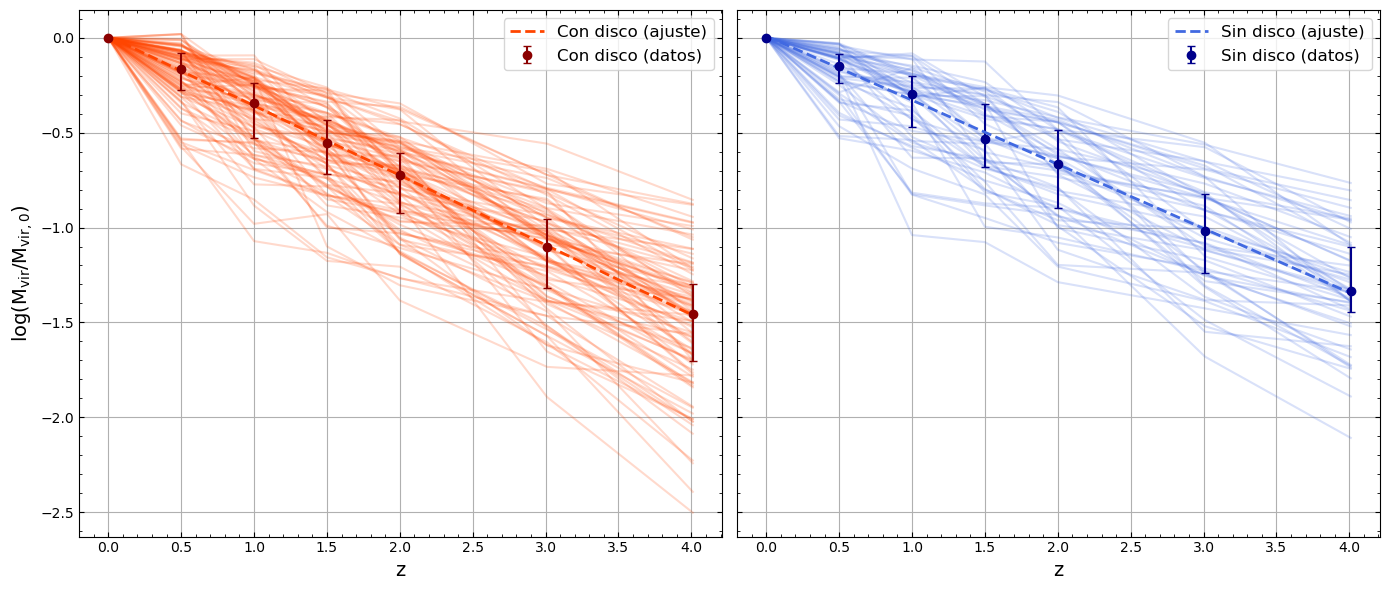

In [40]:
from scipy.optimize import curve_fit

# Ajuste lineal a las curvas de Mvir/Mvir0 vs z en escala logarítmica

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

def linear_fit(z, a, b):
    """Función lineal: y = a*z + b"""
    return a*z + b

def other_fit(z, a, b):
    """Función: y = b*ln(1+z) + a*z"""
    return b*np.log(1+z) + a*z

def plot_group_with_fit(ax, halos, color, color2, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir = np.array(row['Mvir'])/row['Mvir'][row['z'] == 0]
        ax.plot(z, np.log10(mvir), color=color, alpha=0.2)

    # Agrupar por z para obtener medianas
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    mvir_q25    = np.array([np.percentile(mvir_by_z[zz], 25) for zz in z_vals])
    mvir_q75    = np.array([np.percentile(mvir_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(
        z_vals, np.log10(mvir_median),
        yerr=[
            np.log10(mvir_median) - np.log10(mvir_q25),
            np.log10(mvir_q75)    - np.log10(mvir_median)
        ],
        fmt='o', color=color2, ecolor=color2, capsize=3,
        label=label + ' (datos)'
    )

    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mvir_median))
    perr = np.sqrt(np.diag(pcov))

    a, b = popt
    da, db = perr

    # Errores relativos en %
    rel_da = 100 * da / abs(a) if a != 0 else np.nan
    rel_db = 100 * db / abs(b) if b != 0 else np.nan

    # Curva suave del ajuste
    z_smooth = np.linspace(z_vals.min(), z_vals.max(), 200)
    fit_smooth = linear_fit(z_smooth, *popt)

    # Graficar ajuste
    ax.plot(z_smooth, fit_smooth, '--', color=color, linewidth=2,
            label=f'{label} (ajuste)')

    ax.set_xlabel("z", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=12)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')

    # Mostrar ecuación del ajuste con errores relativos
    print(f"{label}:")
    print(
        "log(Mvir/Mvir0) = "
        f"({a:.4f} ± {da:.4f}, rel {rel_da:.2f}%) * z + "
        f"({b:.4f} ± {db:.4f}, rel {rel_db:.2f}%)"
    )
    R2 = 1 - np.var(np.log10(mvir_median) - linear_fit(z_vals, *popt)) / np.var(np.log10(mvir_median))
    print(f"R² = {R2:.4f}")
    print()

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group_with_fit(axs[0], halos_disk, color='orangered', color2='darkred', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group_with_fit(axs[1], halos_nodisk, color='royalblue', color2='darkblue', label='Sin disco')

axs[0].set_ylabel(r"$\log(\rm{M}_{\rm vir}/\rm{M}_{\rm vir,0})$", fontsize=14)

plt.tight_layout()
plt.savefig(results_path + 'Mvir_Mvir0_fit_disk_nodisk_T3.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
def fit_group(halos):
    # Agrupar por z para obtener medianas
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mvir_median))
    perr = np.sqrt(np.diag(pcov))  # errores estándar
    
    return z_vals, np.log10(mvir_median), popt, perr

# Ajustar ambos grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

z_disk, y_disk, popt_disk, perr_disk = fit_group(halos_disk)
z_nodisk, y_nodisk, popt_nodisk, perr_nodisk = fit_group(halos_nodisk)

def test_param(param_name, val1, err1, val2, err2):
    """
    Prueba de hipótesis para comparar dos parámetros ajustados usando t-test.
    H0: val1 == val2
    H1: val1 != val2
    """
    diff = val1 - val2
    se = np.sqrt(err1**2 + err2**2)
    t_stat = diff / se
    
    # Grados de libertad (aproximación de Welch-Satterthwaite)
    # Para errores de ajuste, usamos una aproximación conservadora
    df = ((err1**2 + err2**2)**2) / (err1**4 + err2**4)
    
    # p-valor bilateral usando distribución t
    p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df))
    
    print(f"Prueba de hipótesis para {param_name}:")
    print(f"  {param_name}_disk = {val1:.4f} ± {err1:.4f}")
    print(f"  {param_name}_nodisk = {val2:.4f} ± {err2:.4f}")
    print(f"  Diferencia = {diff:.4f}")
    print(f"  Estadístico t = {t_stat:.3f}")
    print(f"  Grados de libertad ≈ {df:.1f}")
    print(f"  p-valor = {p_val:.4f}")
    
    if p_val < 0.05:
        print("  → Rechazamos H0: diferencia estadísticamente significativa (p < 0.05)")
    else:
        print("  → No rechazamos H0: no hay evidencia suficiente de diferencia (p ≥ 0.05)")
    print()

# Uso
test_param("a", popt_disk[0], perr_disk[0], popt_nodisk[0], perr_nodisk[0])

Prueba de hipótesis para a:
  a_disk = -0.3668 ± 0.0033
  a_nodisk = -0.3380 ± 0.0067
  Diferencia = -0.0289
  Estadístico t = -3.883
  Grados de libertad ≈ 1.5
  p-valor = 0.0967
  → No rechazamos H0: no hay evidencia suficiente de diferencia (p ≥ 0.05)



In [42]:
# Función lineal para el ajuste
def linear_fit(z, a, b):
    """Función lineal: y = a*z + b"""
    return a*z + b

def fit_group_parameters(halos):
    """Ajusta la curva lineal y devuelve parámetros con errores"""
    # Agrupar por z para obtener medianas
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mvir_median))
    perr = np.sqrt(np.diag(pcov))  # errores estándar
    
    return popt, perr, z_vals, mvir_median

# Ajustar ambos grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

popt_disk, perr_disk, z_disk, mvir_median_disk = fit_group_parameters(halos_disk)
popt_nodisk, perr_nodisk, z_nodisk, mvir_median_nodisk = fit_group_parameters(halos_nodisk)

print("=" * 70)
print("PRUEBA DE HIPÓTESIS: Mvir/Mvir0 vs z")
print("Modelo: log10(Mvir/Mvir0) = a*z + b")
print("=" * 70)

# Test para parámetro 'a' (pendiente)
print("\n--- Parámetro a (pendiente) ---")
print(f"Con disco:    a = {popt_disk[0]:.4f} ± {perr_disk[0]:.4f}")
print(f"Sin disco:    a = {popt_nodisk[0]:.4f} ± {perr_nodisk[0]:.4f}")

diff_a = popt_disk[0] - popt_nodisk[0]
se_a = np.sqrt(perr_disk[0]**2 + perr_nodisk[0]**2)
t_stat_a = diff_a / se_a
p_val_a = 2*(1 - stats.norm.cdf(abs(t_stat_a)))

print(f"\nDiferencia:   {diff_a:.4f}")
print(f"t-statistic:  {t_stat_a:.3f}")
print(f"p-value:      {p_val_a:.4f}")

if p_val_a < 0.05:
    print("✓ Diferencia SIGNIFICATIVA en pendiente (p < 0.05)")
    print("  → Las historias de acreción de masa virial difieren entre halos con y sin disco")
else:
    print("✗ No hay diferencia significativa en pendiente (p ≥ 0.05)")
    print("  → Las historias de acreción de masa virial son similares")

# Test para parámetro 'b' (intercepto)
print("\n--- Parámetro b (intercepto) ---")
print(f"Con disco:    b = {popt_disk[1]:.4f} ± {perr_disk[1]:.4f}")
print(f"Sin disco:    b = {popt_nodisk[1]:.4f} ± {perr_nodisk[1]:.4f}")

diff_b = popt_disk[1] - popt_nodisk[1]
se_b = np.sqrt(perr_disk[1]**2 + perr_nodisk[1]**2)
t_stat_b = diff_b / se_b
p_val_b = 2*(1 - stats.norm.cdf(abs(t_stat_b)))

print(f"\nDiferencia:   {diff_b:.4f}")
print(f"t-statistic:  {t_stat_b:.3f}")
print(f"p-value:      {p_val_b:.4f}")

if p_val_b < 0.05:
    print("✓ Diferencia SIGNIFICATIVA en intercepto (p < 0.05)")
else:
    print("✗ No hay diferencia significativa en intercepto (p ≥ 0.05)")

print("\n" + "=" * 70)
print(f"Tamaño de muestra:")
print(f"  Halos con disco:  {len(halos_disk)}")
print(f"  Halos sin disco:  {len(halos_nodisk)}")
print("=" * 70)

PRUEBA DE HIPÓTESIS: Mvir/Mvir0 vs z
Modelo: log10(Mvir/Mvir0) = a*z + b

--- Parámetro a (pendiente) ---
Con disco:    a = -0.3668 ± 0.0033
Sin disco:    a = -0.3380 ± 0.0067

Diferencia:   -0.0289
t-statistic:  -3.883
p-value:      0.0001
✓ Diferencia SIGNIFICATIVA en pendiente (p < 0.05)
  → Las historias de acreción de masa virial difieren entre halos con y sin disco

--- Parámetro b (intercepto) ---
Con disco:    b = 0.0087 ± 0.0072
Sin disco:    b = 0.0092 ± 0.0144

Diferencia:   -0.0005
t-statistic:  -0.029
p-value:      0.9771
✗ No hay diferencia significativa en intercepto (p ≥ 0.05)

Tamaño de muestra:
  Halos con disco:  103
  Halos sin disco:  57


In [43]:
# Extraer las pendientes de los ajustes lineales para cada grupo

def get_slopes_for_halos(halos):
    """Calcula la pendiente del ajuste lineal para cada halo"""
    slopes = []
    
    for i, row in halos.iterrows():
        z_vals = np.array(row['z'])
        mvir_ratio = np.array(row['Mvir']) / row['Mvir'][row['z'] == 0]
        log_mvir = np.log10(mvir_ratio)
        
        # Ajuste lineal individual
        try:
            popt, _ = curve_fit(linear_fit, z_vals, log_mvir)
            slopes.append(popt[0])  # pendiente
        except:
            continue
    
    return np.array(slopes)

# Obtener pendientes para cada grupo
slopes_disk = get_slopes_for_halos(halos_disk)
slopes_nodisk = get_slopes_for_halos(halos_nodisk)

print("=" * 80)
print("PRUEBA DE HIPÓTESIS: COMPARACIÓN DE PENDIENTES")
print("=" * 80)
print(f"\nHalos con disco: n={len(slopes_disk)}")
print(f"  Media: {np.mean(slopes_disk):.4f}")
print(f"  Mediana: {np.median(slopes_disk):.4f}")
print(f"  Desv. estándar: {np.std(slopes_disk):.4f}")

print(f"\nHalos sin disco: n={len(slopes_nodisk)}")
print(f"  Media: {np.mean(slopes_nodisk):.4f}")
print(f"  Mediana: {np.median(slopes_nodisk):.4f}")
print(f"  Desv. estándar: {np.std(slopes_nodisk):.4f}")

# Test de normalidad (Shapiro-Wilk)
print("\n" + "-" * 80)
print("TEST DE NORMALIDAD (Shapiro-Wilk)")
print("-" * 80)
_, p_disk = stats.shapiro(slopes_disk)
_, p_nodisk = stats.shapiro(slopes_nodisk)
print(f"Con disco: p-valor = {p_disk:.4f}")
print(f"Sin disco: p-valor = {p_nodisk:.4f}")

# Test de Mann-Whitney U (no paramétrico)
print("\n" + "-" * 80)
print("TEST DE MANN-WHITNEY U")
print("-" * 80)
statistic_mw, pvalue_mw = stats.mannwhitneyu(slopes_disk, slopes_nodisk, alternative='two-sided')
print(f"Estadístico: {statistic_mw:.2f}")
print(f"P-valor: {pvalue_mw:.4f}")
if pvalue_mw < 0.05:
    print("→ Las pendientes son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)")
else:
    print("→ No hay diferencia significativa entre las pendientes")

# Test t de Student (paramétrico)
print("\n" + "-" * 80)
print("TEST T DE STUDENT (dos muestras)")
print("-" * 80)
statistic_t, pvalue_t = stats.ttest_ind(slopes_disk, slopes_nodisk)
print(f"Estadístico t: {statistic_t:.4f}")
print(f"P-valor: {pvalue_t:.4f}")
if pvalue_t < 0.05:
    print("→ Las pendientes son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)")
else:
    print("→ No hay diferencia significativa entre las pendientes")

print("\n" + "=" * 80)

PRUEBA DE HIPÓTESIS: COMPARACIÓN DE PENDIENTES

Halos con disco: n=103
  Media: -0.3744
  Mediana: -0.3635
  Desv. estándar: 0.0859

Halos sin disco: n=56
  Media: -0.3303
  Mediana: -0.3269
  Desv. estándar: 0.0751

--------------------------------------------------------------------------------
TEST DE NORMALIDAD (Shapiro-Wilk)
--------------------------------------------------------------------------------
Con disco: p-valor = 0.0087
Sin disco: p-valor = 0.2370

--------------------------------------------------------------------------------
TEST DE MANN-WHITNEY U
--------------------------------------------------------------------------------
Estadístico: 2023.00
P-valor: 0.0019
→ Las pendientes son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)

--------------------------------------------------------------------------------
TEST T DE STUDENT (dos muestras)
--------------------------------------------------------------------------------
Estadístico t: -3.2125
P-valor: 0.0016
→ Las pendi

Tipo 1:
log(Mvir/Mvir0) = (-0.2924 ± 0.0035, rel 1.21%) * z + (0.0064 ± 0.0076, rel 119.78%)
R² = 0.9993

Tipo 2:
log(Mvir/Mvir0) = (-0.3912 ± 0.0038, rel 0.96%) * z + (0.0076 ± 0.0081, rel 106.92%)
R² = 0.9995

Tipo 1:
log(Mvir/Mvir0) = (-0.2409 ± 0.0073, rel 3.03%) * z + (-0.0139 ± 0.0157, rel 113.14%)
R² = 0.9954

Tipo 2:
log(Mvir/Mvir0) = (-0.3583 ± 0.0146, rel 4.08%) * z + (-0.0210 ± 0.0316, rel 150.49%)
R² = 0.9917



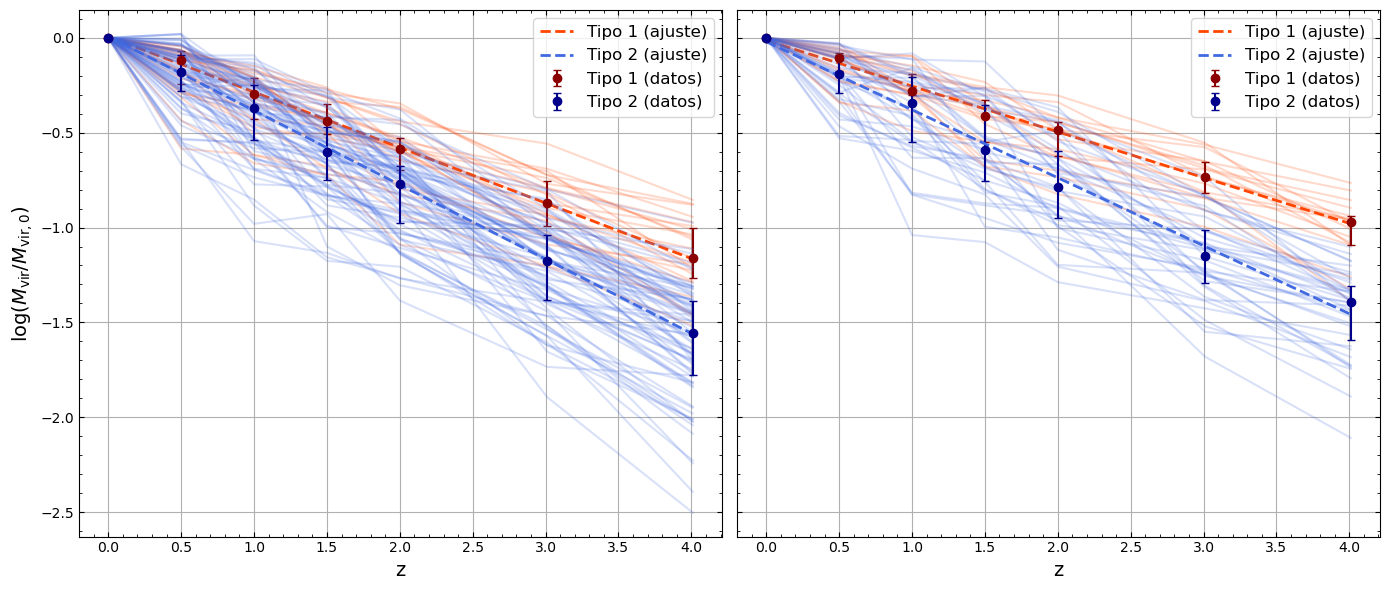

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_group_with_fit(axs[0], halos_Mdomup[halos_Mdomup['has_disk'] == 1], color='orangered', color2='darkred', label='Tipo 1')
plot_group_with_fit(axs[0], halos_Mdomdown[halos_Mdomdown['has_disk'] == 1], color='royalblue', color2='darkblue', label='Tipo 2')
#axs[0].set_title('Halos con disco')

plot_group_with_fit(axs[1], halos_Mdomup[halos_Mdomup['has_disk'] == 0], color='orangered', color2='darkred', label='Tipo 1')
plot_group_with_fit(axs[1], halos_Mdomdown[halos_Mdomdown['has_disk'] == 0], color='royalblue', color2='darkblue', label='Tipo 2')
#axs[1].set_title('Halos sin disco')

axs[0].set_ylabel(r"$\log(M_{\rm vir}/M_{\rm vir,0})$", fontsize=14)
plt.tight_layout()
plt.savefig(results_path + 'Mvir_Mvir0_fit_accretion_types_disk_nodisk_T3.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
from scipy.stats import ttest_ind

# Realizar pruebas de hipótesis para comparar las curvas Type 1 vs Type 2 
# tanto para halos con disco como sin disco


def linear_fit(z, a, b):
    """Función lineal: y = a*z + b"""
    return a*z + b

def fit_group_parameters(halos):
    """Ajusta la curva lineal y devuelve parámetros con errores"""
    # Agrupar por z para obtener medianas
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mvir_median))
    perr = np.sqrt(np.diag(pcov))  # errores estándar
    
    return popt, perr

def test_parameters(group1, group2, label1, label2):
    """Realiza test de hipótesis para comparar parámetros entre dos grupos"""
    popt1, perr1 = fit_group_parameters(group1)
    popt2, perr2 = fit_group_parameters(group2)
    
    print(f"\n=== Comparación {label1} vs {label2} ===")
    
    # Test para parámetro 'a' (pendiente)
    diff_a = popt1[0] - popt2[0]
    se_a = np.sqrt(perr1[0]**2 + perr2[0]**2)
    t_stat_a = diff_a / se_a
    p_val_a = 2*(1 - stats.norm.cdf(abs(t_stat_a)))
    
    print(f"Parámetro a (pendiente):")
    print(f"  {label1}: {popt1[0]:.4f} ± {perr1[0]:.4f}")
    print(f"  {label2}: {popt2[0]:.4f} ± {perr2[0]:.4f}")
    print(f"  Diferencia: {diff_a:.4f}")
    print(f"  t-statistic: {t_stat_a:.3f}")
    print(f"  p-value: {p_val_a:.4f}")
    
    if p_val_a < 0.05:
        print("  → Diferencia SIGNIFICATIVA en pendiente")
    else:
        print("  → No hay diferencia significativa en pendiente")
    
    # Test para parámetro 'b' (intercepto)
    diff_b = popt1[1] - popt2[1]
    se_b = np.sqrt(perr1[1]**2 + perr2[1]**2)
    t_stat_b = diff_b / se_b
    p_val_b = 2*(1 - stats.norm.cdf(abs(t_stat_b)))
    
    print(f"\nParámetro b (intercepto):")
    print(f"  {label1}: {popt1[1]:.4f} ± {perr1[1]:.4f}")
    print(f"  {label2}: {popt2[1]:.4f} ± {perr2[1]:.4f}")
    print(f"  Diferencia: {diff_b:.4f}")
    print(f"  t-statistic: {t_stat_b:.3f}")
    print(f"  p-value: {p_val_b:.4f}")
    
    if p_val_b < 0.05:
        print("  → Diferencia SIGNIFICATIVA en intercepto")
    else:
        print("  → No hay diferencia significativa en intercepto")

# Separar grupos según Mdom evolution y presencia de disco
type1_with_disk = halos_Mdomup[halos_Mdomup['has_disk'] == 1]
type2_with_disk = halos_Mdomdown[halos_Mdomdown['has_disk'] == 1]
type1_without_disk = halos_Mdomup[halos_Mdomup['has_disk'] == 0]
type2_without_disk = halos_Mdomdown[halos_Mdomdown['has_disk'] == 0]

print("PRUEBAS DE HIPÓTESIS PARA CURVAS MVIR/MVIR0 vs z")
print("=" * 60)

# Test para halos CON disco: Type 1 vs Type 2
test_parameters(type1_with_disk, type2_with_disk, 
               "Type 1 (con disco)", "Type 2 (con disco)")

# Test para halos SIN disco: Type 1 vs Type 2  
test_parameters(type1_without_disk, type2_without_disk,
               "Type 1 (sin disco)", "Type 2 (sin disco)")

print(f"\nTamaños de muestra:")
print(f"Type 1 con disco: {len(type1_with_disk)} halos")
print(f"Type 2 con disco: {len(type2_with_disk)} halos")
print(f"Type 1 sin disco: {len(type1_without_disk)} halos")
print(f"Type 2 sin disco: {len(type2_without_disk)} halos")

PRUEBAS DE HIPÓTESIS PARA CURVAS MVIR/MVIR0 vs z

=== Comparación Type 1 (con disco) vs Type 2 (con disco) ===
Parámetro a (pendiente):
  Type 1 (con disco): -0.2924 ± 0.0035
  Type 2 (con disco): -0.3912 ± 0.0038
  Diferencia: 0.0989
  t-statistic: 19.165
  p-value: 0.0000
  → Diferencia SIGNIFICATIVA en pendiente

Parámetro b (intercepto):
  Type 1 (con disco): 0.0064 ± 0.0076
  Type 2 (con disco): 0.0076 ± 0.0081
  Diferencia: -0.0012
  t-statistic: -0.112
  p-value: 0.9111
  → No hay diferencia significativa en intercepto

=== Comparación Type 1 (sin disco) vs Type 2 (sin disco) ===
Parámetro a (pendiente):
  Type 1 (sin disco): -0.2409 ± 0.0073
  Type 2 (sin disco): -0.3583 ± 0.0146
  Diferencia: 0.1174
  t-statistic: 7.184
  p-value: 0.0000
  → Diferencia SIGNIFICATIVA en pendiente

Parámetro b (intercepto):
  Type 1 (sin disco): -0.0139 ± 0.0157
  Type 2 (sin disco): -0.0210 ± 0.0316
  Diferencia: 0.0071
  t-statistic: 0.200
  p-value: 0.8414
  → No hay diferencia significativa 

COMPARACIÓN: Halos CON DISCO
Tipo 1 (Mdom crece): n=23, media=-0.2833, mediana=-0.2937, std=0.0396
Tipo 2 (Mdom decrece): n=80, media=-0.4006, mediana=-0.3846, std=0.0773
----------------------------------------
Test Mann-Whitney U: p-valor = 1.53e-10
Test t-Student (Welch): p-valor = 1.30e-14
>>> CONCLUSIÓN: Las distribuciones de pendientes son SIGNIFICATIVAMENTE DIFERENTES.


COMPARACIÓN: Halos SIN DISCO
Tipo 1 (Mdom crece): n=17, media=-0.2504, mediana=-0.2466, std=0.0335
Tipo 2 (Mdom decrece): n=39, media=-0.3651, mediana=-0.3400, std=0.0601
----------------------------------------
Test Mann-Whitney U: p-valor = 2.99e-08
Test t-Student (Welch): p-valor = 6.41e-12
>>> CONCLUSIÓN: Las distribuciones de pendientes son SIGNIFICATIVAMENTE DIFERENTES.




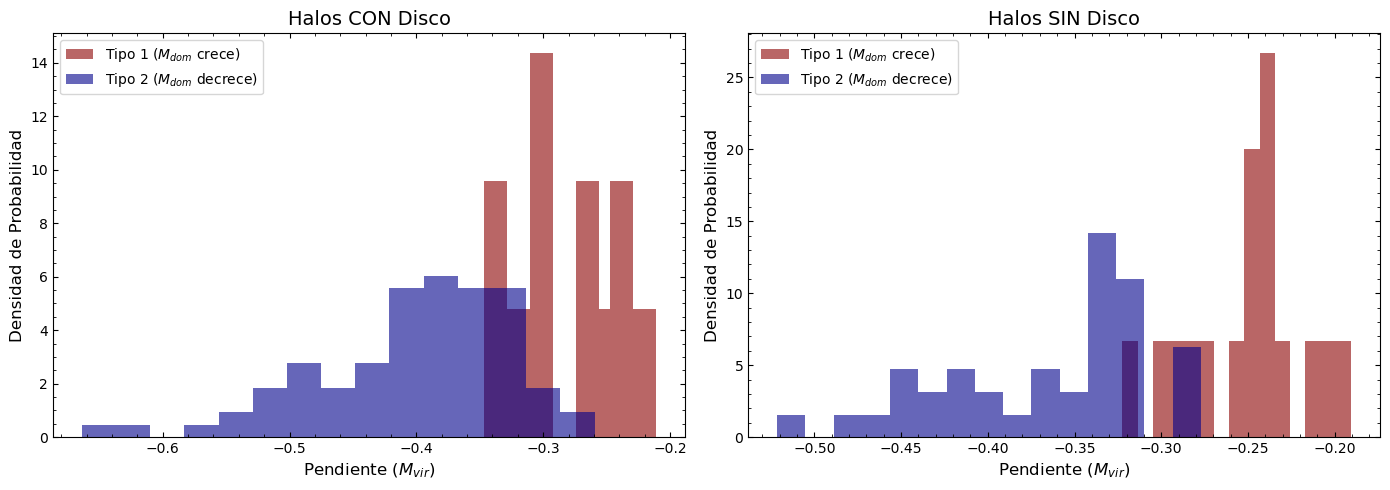

In [46]:
from scipy.stats import mannwhitneyu, ttest_ind

def get_individual_slopes(halos):
    """
    Calcula la pendiente 'a' del ajuste lineal log(Mvir/Mvir0) = a*z + b
    para cada halo individualmente.
    """
    slopes = []
    for i, row in halos.iterrows():
        z_vals = np.array(row['z'])
        # Evitar divisiones por cero o logs inválidos si los hay
        if row['Mvir'][row['z'] == 0] == 0: continue
        
        mvir_ratio = np.array(row['Mvir']) / row['Mvir'][row['z'] == 0]
        
        # Filtrar valores <= 0 para el log
        valid_mask = mvir_ratio > 0
        if np.sum(valid_mask) < 3: continue # Necesitamos al menos unos puntos para ajustar
        
        log_mvir = np.log10(mvir_ratio[valid_mask])
        z_valid = z_vals[valid_mask]
        
        try:
            # Ajuste lineal: y = a*x + b
            # polyfit grado 1 devuelve [pendiente, intercepto]
            p = np.polyfit(z_valid, log_mvir, 1)
            slopes.append(p[0])
        except:
            continue
            
    return np.array(slopes)

# 1. Obtener pendientes individuales para cada subgrupo
slopes_t1_disk = get_individual_slopes(type1_with_disk)
slopes_t2_disk = get_individual_slopes(type2_with_disk)

slopes_t1_nodisk = get_individual_slopes(type1_without_disk)
slopes_t2_nodisk = get_individual_slopes(type2_without_disk)

def report_comparison(group1, group2, label1, label2, title):
    print("="*80)
    print(f"COMPARACIÓN: {title}")
    print("="*80)
    
    # Estadísticas básicas
    print(f"{label1}: n={len(group1)}, media={np.mean(group1):.4f}, mediana={np.median(group1):.4f}, std={np.std(group1):.4f}")
    print(f"{label2}: n={len(group2)}, media={np.mean(group2):.4f}, mediana={np.median(group2):.4f}, std={np.std(group2):.4f}")
    
    # Test de Mann-Whitney U (No paramétrico, robusto a outliers y no normalidad)
    stat_u, p_u = mannwhitneyu(group1, group2)
    
    # Test T de Student (Paramétrico, asume normalidad/n grande)
    stat_t, p_t = ttest_ind(group1, group2, equal_var=False)
    
    print("-" * 40)
    print(f"Test Mann-Whitney U: p-valor = {p_u:.2e}")
    print(f"Test t-Student (Welch): p-valor = {p_t:.2e}")
    
    if p_u < 0.05:
        print(">>> CONCLUSIÓN: Las distribuciones de pendientes son SIGNIFICATIVAMENTE DIFERENTES.")
    else:
        print(">>> CONCLUSIÓN: No hay evidencia suficiente para distinguir las pendientes.")
    print("\n")

# 2. Ejecutar comparaciones
report_comparison(slopes_t1_disk, slopes_t2_disk, 
                 "Tipo 1 (Mdom crece)", "Tipo 2 (Mdom decrece)", 
                 "Halos CON DISCO")

report_comparison(slopes_t1_nodisk, slopes_t2_nodisk, 
                 "Tipo 1 (Mdom crece)", "Tipo 2 (Mdom decrece)", 
                 "Halos SIN DISCO")

# 3. Visualización
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Histograma Con Disco
axs[0].hist(slopes_t1_disk, bins=15, alpha=0.6, density=True, color='darkred', label='Tipo 1 ($M_{dom}$ crece)')
axs[0].hist(slopes_t2_disk, bins=15, alpha=0.6, density=True, color='darkblue', label='Tipo 2 ($M_{dom}$ decrece)')
axs[0].set_title('Halos CON Disco', fontsize=14)
axs[0].set_xlabel(r'Pendiente ($M_{vir}$)', fontsize=12)
axs[0].set_ylabel('Densidad de Probabilidad', fontsize=12)
axs[0].legend()

# Histograma Sin Disco
axs[1].hist(slopes_t1_nodisk, bins=15, alpha=0.6, density=True, color='darkred', label='Tipo 1 ($M_{dom}$ crece)')
axs[1].hist(slopes_t2_nodisk, bins=15, alpha=0.6, density=True, color='darkblue', label='Tipo 2 ($M_{dom}$ decrece)')
axs[1].set_title('Halos SIN Disco', fontsize=14)
axs[1].set_xlabel(r'Pendiente ($M_{vir}$)', fontsize=12)
axs[1].set_ylabel('Densidad de Probabilidad', fontsize=12)
axs[1].legend()

axs[0].minorticks_on()
axs[0].tick_params(axis='both', which='both', top=True, right=True, direction='in')

axs[1].minorticks_on()
axs[1].tick_params(axis='both', which='both', top=True, right=True, direction='in')

plt.tight_layout()
#guardar la figura
plt.savefig(results_path + 'Pendiente_distribuciones_accretion_types_disk_nodisk_T3.png', dpi=300, bbox_inches='tight')
plt.show()

COMPARACIÓN: TODOS LOS HALOS (Con y Sin Disco)
Tipo 1 (Mdom crece): n=40, media=-0.2693, mediana=-0.2634, std=0.0405
Tipo 2 (Mdom decrece): n=119, media=-0.3890, mediana=-0.3756, std=0.0740
----------------------------------------
Test Mann-Whitney U: p-valor = 4.42e-17
Test t-Student (Welch): p-valor = 3.69e-24
>>> CONCLUSIÓN: Las distribuciones de pendientes son SIGNIFICATIVAMENTE DIFERENTES.




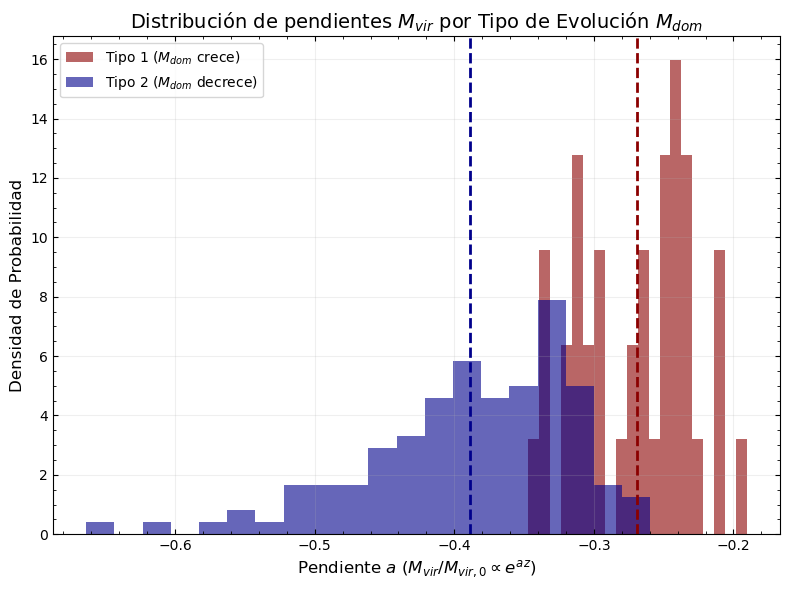

In [61]:
# Combinar halos con y sin disco para cada tipo
type1_all = pd.concat([type1_with_disk, type1_without_disk])
type2_all = pd.concat([type2_with_disk, type2_without_disk])

# Calcular pendientes individuales
slopes_t1_all = get_individual_slopes(type1_all)
slopes_t2_all = get_individual_slopes(type2_all)

# Reportar comparación
report_comparison(slopes_t1_all, slopes_t2_all, 
                 "Tipo 1 (Mdom crece)", "Tipo 2 (Mdom decrece)", 
                 "TODOS LOS HALOS (Con y Sin Disco)")

# Visualización
plt.figure(figsize=(8, 6))

# Histograma
plt.hist(slopes_t1_all, bins=20, alpha=0.6, density=True, color='darkred', label='Tipo 1 ($M_{dom}$ crece)')
plt.hist(slopes_t2_all, bins=20, alpha=0.6, density=True, color='darkblue', label='Tipo 2 ($M_{dom}$ decrece)')

# Líneas de media
plt.axvline(np.mean(slopes_t1_all), color='darkred', linestyle='--', lw=2)
plt.axvline(np.mean(slopes_t2_all), color='darkblue', linestyle='--', lw=2)

plt.title('Distribución de pendientes $M_{vir}$ por Tipo de Evolución $M_{dom}$', fontsize=14)
plt.xlabel(r'Pendiente $a$ ($M_{vir}/M_{vir,0} \propto e^{az}$)', fontsize=12)
plt.ylabel('Densidad de Probabilidad', fontsize=12)
plt.legend()

plt.minorticks_on()
plt.tick_params(axis='both', which='both', top=True, right=True, direction='in')
plt.grid(alpha=0.2)

plt.tight_layout()
#plt.savefig(results_path + 'Pendiente_distribuciones_accretion_types_ALL_T3.png', dpi=300, bbox_inches='tight')
plt.show()

FRACTION OF HALOS BY EVOLUTION TYPE (Mdom)

HALOS WITH DISK (Total: 103)
  Type 1 (Growth):    23 (22.3%)
  Type 2 (Loss):      80 (77.7%)

HALOS WITHOUT DISK (Total: 57)
  Type 1 (Growth):    17 (29.8%)
  Type 2 (Loss):      39 (68.4%)


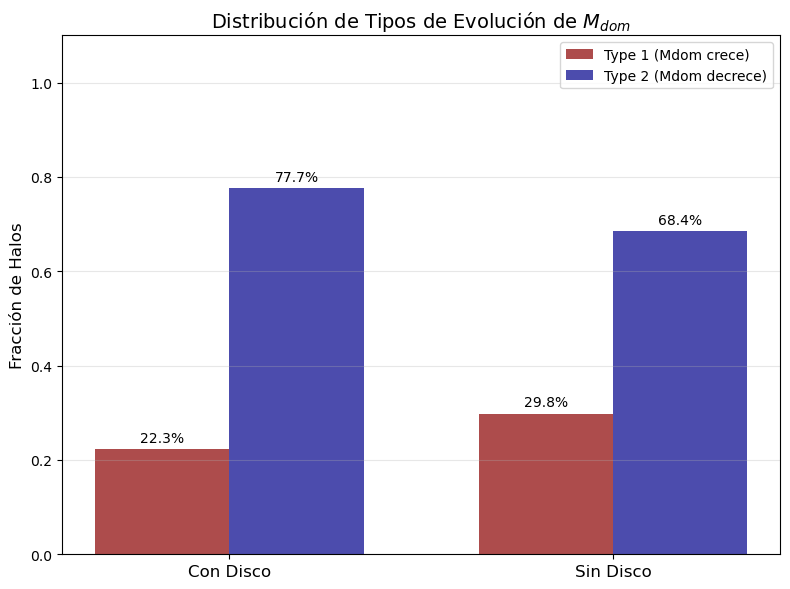

In [64]:
# Calculate total counts for disk and no-disk populations
n_disk_total = len(history_accretion[history_accretion['has_disk'] == 1])
n_nodisk_total = len(history_accretion[history_accretion['has_disk'] == 0])

# Calculate counts for each type within disk population
n_type1_disk = len(halos_Mdomup[halos_Mdomup['has_disk'] == 1])
n_type2_disk = len(halos_Mdomdown[halos_Mdomdown['has_disk'] == 1])

# Calculate counts for each type within no-disk population
n_type1_nodisk = len(halos_Mdomup[halos_Mdomup['has_disk'] == 0])
n_type2_nodisk = len(halos_Mdomdown[halos_Mdomdown['has_disk'] == 0])

# Calculate fractions
frac_type1_disk = n_type1_disk / n_disk_total
frac_type2_disk = n_type2_disk / n_disk_total

frac_type1_nodisk = n_type1_nodisk / n_nodisk_total
frac_type2_nodisk = n_type2_nodisk / n_nodisk_total

print("=" * 60)
print("FRACTION OF HALOS BY EVOLUTION TYPE (Mdom)")
print("=" * 60)

print(f"\nHALOS WITH DISK (Total: {n_disk_total})")
print(f"  Type 1 (Growth):   {n_type1_disk:3d} ({frac_type1_disk:.1%})")
print(f"  Type 2 (Loss):     {n_type2_disk:3d} ({frac_type2_disk:.1%})")

print(f"\nHALOS WITHOUT DISK (Total: {n_nodisk_total})")
print(f"  Type 1 (Growth):   {n_type1_nodisk:3d} ({frac_type1_nodisk:.1%})")
print(f"  Type 2 (Loss):     {n_type2_nodisk:3d} ({frac_type2_nodisk:.1%})")

# Create a bar plot for visualization
labels = ['Con Disco', 'Sin Disco']
type1_fracs = [frac_type1_disk, frac_type1_nodisk]
type2_fracs = [frac_type2_disk, frac_type2_nodisk]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, type1_fracs, width, label='Type 1 (Mdom crece)', color='darkred', alpha=0.7)
rects2 = ax.bar(x + width/2, type2_fracs, width, label='Type 2 (Mdom decrece)', color='darkblue', alpha=0.7)

ax.set_ylabel('Fracción de Halos', fontsize=12)
ax.set_title('Distribución de Tipos de Evolución de $M_{dom}$', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

# Add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
#plt.savefig(results_path + 'Fraction_types_Mdom_disk_nodisk_T3.png', dpi=300, bbox_inches='tight')
plt.show()

FRACTION OF DISK/NO-DISK HALOS BY EVOLUTION TYPE

TYPE 1: Mdom GROWTH (Total: 40)
  With Disk:     23 (57.5%)
  Without Disk:  17 (42.5%)

TYPE 2: Mdom LOSS (Total: 119)
  With Disk:     80 (67.2%)
  Without Disk:  39 (32.8%)


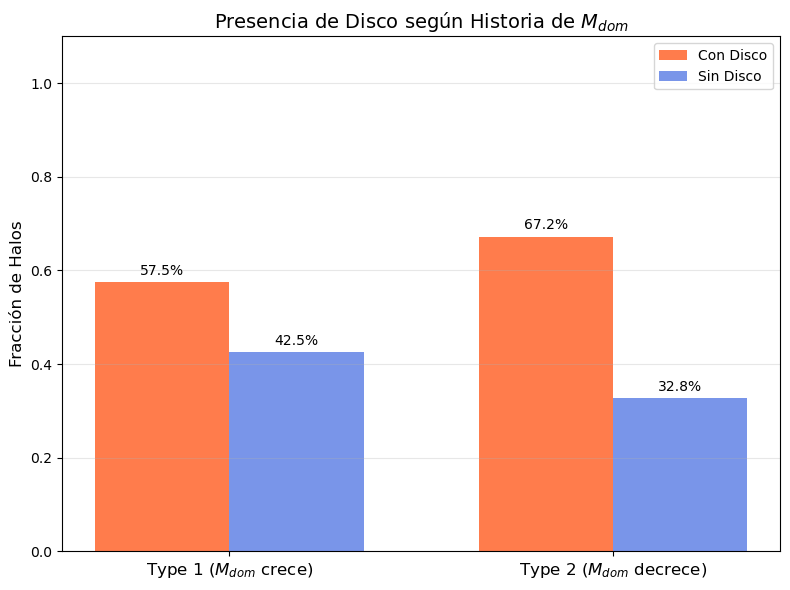

In [65]:
# Calculate total counts for Type 1 and Type 2 populations
n_type1_total = len(halos_Mdomup)
n_type2_total = len(halos_Mdomdown)

# Calculate counts for disk/no-disk within Type 1 (Growth)
n_disk_type1 = len(halos_Mdomup[halos_Mdomup['has_disk'] == 1])
n_nodisk_type1 = len(halos_Mdomup[halos_Mdomup['has_disk'] == 0])

# Calculate counts for disk/no-disk within Type 2 (Loss)
n_disk_type2 = len(halos_Mdomdown[halos_Mdomdown['has_disk'] == 1])
n_nodisk_type2 = len(halos_Mdomdown[halos_Mdomdown['has_disk'] == 0])

# Calculate fractions
frac_disk_type1 = n_disk_type1 / n_type1_total
frac_nodisk_type1 = n_nodisk_type1 / n_type1_total

frac_disk_type2 = n_disk_type2 / n_type2_total
frac_nodisk_type2 = n_nodisk_type2 / n_type2_total

print("=" * 60)
print("FRACTION OF DISK/NO-DISK HALOS BY EVOLUTION TYPE")
print("=" * 60)

print(f"\nTYPE 1: Mdom GROWTH (Total: {n_type1_total})")
print(f"  With Disk:    {n_disk_type1:3d} ({frac_disk_type1:.1%})")
print(f"  Without Disk: {n_nodisk_type1:3d} ({frac_nodisk_type1:.1%})")

print(f"\nTYPE 2: Mdom LOSS (Total: {n_type2_total})")
print(f"  With Disk:    {n_disk_type2:3d} ({frac_disk_type2:.1%})")
print(f"  Without Disk: {n_nodisk_type2:3d} ({frac_nodisk_type2:.1%})")

# Create a bar plot for visualization
labels = ['Type 1 ($M_{dom}$ crece)', 'Type 2 ($M_{dom}$ decrece)']
disk_fracs = [frac_disk_type1, frac_disk_type2]
nodisk_fracs = [frac_nodisk_type1, frac_nodisk_type2]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, disk_fracs, width, label='Con Disco', color='orangered', alpha=0.7)
rects2 = ax.bar(x + width/2, nodisk_fracs, width, label='Sin Disco', color='royalblue', alpha=0.7)

ax.set_ylabel('Fracción de Halos', fontsize=12)
ax.set_title('Presencia de Disco según Historia de $M_{dom}$', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

# Add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig(results_path + 'Fraction_disk_nodisk_by_Mdom_type_T3.png', dpi=300, bbox_inches='tight')
plt.show()

### Mdom

In [47]:
#fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

def plot_group(ax, halos, color, title):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mdom = np.array(row['Mdom'])/row['Mdom'][row['z'] == 0]
        ax.plot(z, np.log10(mdom), color=color, alpha=0.1)

    # Agrupar por z
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    mdom_q25    = np.array([np.percentile(mdom_by_z[zz], 25) for zz in z_vals])
    mdom_q75    = np.array([np.percentile(mdom_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(z_vals, np.log10(mdom_median),
                yerr=[np.log10(mdom_median)-np.log10(mdom_q25),
                      np.log10(mdom_q75)-np.log10(mdom_median)],
                fmt='o', color=color, ecolor='black', capsize=3,
                label='Mediana ± IQR')

    ax.set_title(title)
    ax.set_xlabel("z")
    
    ax.grid(True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
#plot_group(axs[0], halos_disk, color='orangered', title='Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
#plot_group(axs[1], halos_nodisk, color='royalblue', title='Halos sin disco')

#axs[0].set_ylabel(r"$\log_{10}(M_{\rm dom}/M_{\rm dom,0})$")
#axs[0].legend()

#plt.tight_layout()
#plt.show()

In [48]:
def linear_fit(z, a, b):
    """Función lineal: y = a*z + b"""
    return a*z + b

def plot_group_with_fit(ax, halos, color, color2, label, mass_type='Mdom'):
    """
    Función unificada para graficar halos con ajuste lineal.
    
    Parameters:
    -----------
    ax : matplotlib axis
        Eje donde se graficará
    halos : DataFrame
        DataFrame con los datos de los halos
    color : str
        Color para las líneas individuales y el ajuste
    color2 : str
        Color para los puntos de la mediana
    label : str
        Etiqueta para la leyenda
    mass_type : str, optional (default='Mdom')
        Tipo de masa a graficar: 'Mvir' o 'Mdom'
    """
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mass = np.array(row[mass_type]) / row[mass_type][row['z'] == 0]
        alpha_val = 0.2
        ax.plot(z, np.log10(mass), color=color, alpha=alpha_val)

    # Agrupar por z para obtener medianas
    mass_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row[mass_type]):
            if zz not in mass_by_z:
                mass_by_z[zz] = []
            mass_by_z[zz].append(m / row[mass_type][row['z'] == 0])

    z_vals = np.array(sorted(mass_by_z.keys()))
    mass_median = np.array([np.median(mass_by_z[zz]) for zz in z_vals])
    mass_q25 = np.array([np.percentile(mass_by_z[zz], 25) for zz in z_vals])
    mass_q75 = np.array([np.percentile(mass_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(
        z_vals, np.log10(mass_median),
        yerr=[
            np.log10(mass_median) - np.log10(mass_q25),
            np.log10(mass_q75) - np.log10(mass_median)
        ],
        fmt='o', color=color2, ecolor=color2, capsize=3,
        label=label + ' (datos)'
    )

    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mass_median))
    perr = np.sqrt(np.diag(pcov))

    a, b = popt
    da, db = perr

    # Errores relativos en %
    rel_da = 100 * da / abs(a) if a != 0 else np.nan
    rel_db = 100 * db / abs(b) if b != 0 else np.nan

    # Curva suave del ajuste
    z_smooth = np.linspace(z_vals.min(), z_vals.max(), 200)
    fit_smooth = linear_fit(z_smooth, *popt)

    # Graficar ajuste
    ax.plot(z_smooth, fit_smooth, '--', color=color, linewidth=2,
            label=f'{label} (ajuste)')

    ax.set_xlabel("z", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=12)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')

    # Mostrar ecuación del ajuste con errores relativos
    print(f"{label}:")
    print(
        f"log({mass_type}/{mass_type}0) = "
        f"({a:.4f} ± {da:.4f}, rel {rel_da:.2f}%) * z + "
        f"({b:.4f} ± {db:.4f}, rel {rel_db:.2f}%)"
    )
    R2 = 1 - np.var(np.log10(mass_median) - linear_fit(z_vals, *popt)) / np.var(np.log10(mass_median))
    print(f"R² = {R2:.4f}")
    print()

Mdom

Con disco:
log(Mdom/Mdom0) = (-0.1079 ± 0.0084, rel 7.78%) * z + (0.0418 ± 0.0181, rel 43.35%)
R² = 0.9706

Sin disco:
log(Mdom/Mdom0) = (-0.0653 ± 0.0126, rel 19.22%) * z + (0.0326 ± 0.0271, rel 83.14%)
R² = 0.8441



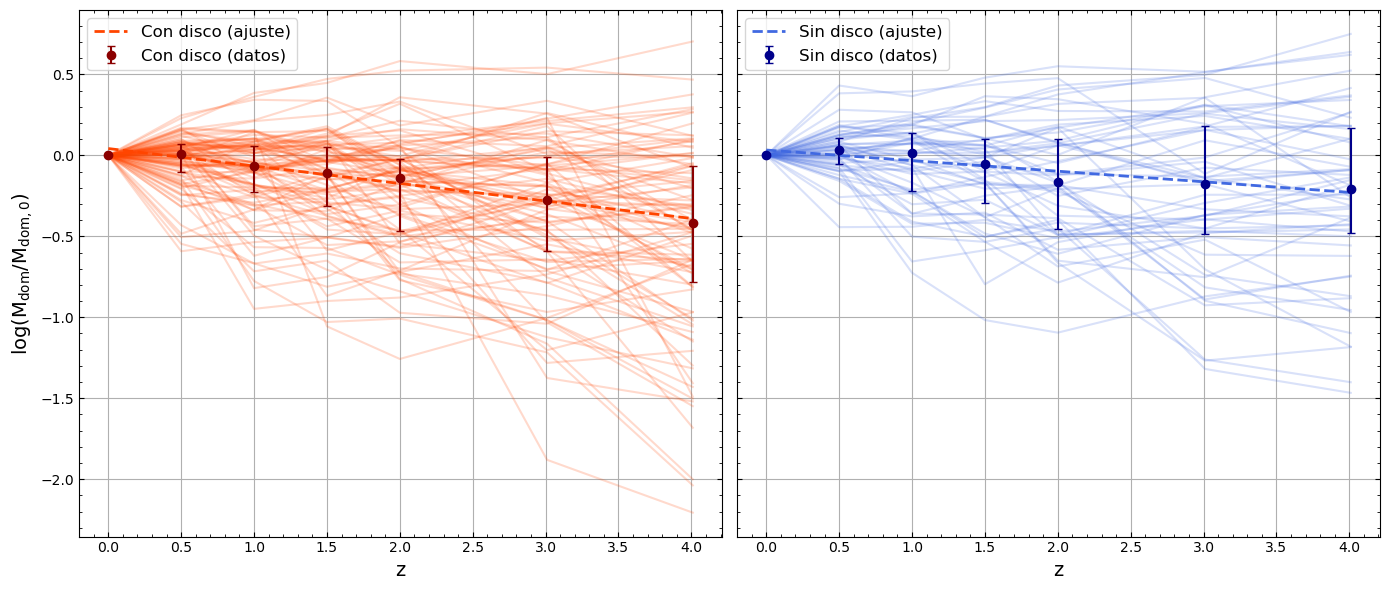

In [49]:
# Ajuste lineal a las curvas de Mdom/Mdom0 vs z en escala logarítmica

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group_with_fit(axs[0], halos_disk, color='orangered', color2='darkred', label='Con disco', mass_type='Mdom')
#axs[0].set_title('Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group_with_fit(axs[1], halos_nodisk, color='royalblue', color2='darkblue', label='Sin disco', mass_type='Mdom')
#axs[1].set_title('Halos sin disco')
axs[0].set_ylabel(r"$\rm \log(M_{dom}/M_{dom,0})$", fontsize=14)
plt.tight_layout()
plt.savefig(results_path + 'Mdom_Mdom0_fit_disk_nodisk_T3.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
# Extraer las pendientes de los ajustes lineales para cada grupo

def get_slopes_for_halos(halos):
    """Calcula la pendiente del ajuste lineal para cada halo"""
    slopes = []
    
    for i, row in halos.iterrows():
        z_vals = np.array(row['z'])
        mdom_ratio = np.array(row['Mdom']) / row['Mdom'][row['z'] == 0]
        log_mdom = np.log10(mdom_ratio)
        
        # Ajuste lineal individual
        try:
            popt, _ = curve_fit(linear_fit, z_vals, log_mdom)
            slopes.append(popt[0])  # pendiente
        except:
            continue
    
    return np.array(slopes)

# Obtener pendientes para cada grupo
slopes_disk = get_slopes_for_halos(halos_disk)
slopes_nodisk = get_slopes_for_halos(halos_nodisk)

print("=" * 80)
print("PRUEBA DE HIPÓTESIS: COMPARACIÓN DE PENDIENTES")
print("=" * 80)
print(f"\nHalos con disco: n={len(slopes_disk)}")
print(f"  Media: {np.mean(slopes_disk):.4f}")
print(f"  Mediana: {np.median(slopes_disk):.4f}")
print(f"  Desv. estándar: {np.std(slopes_disk):.4f}")

print(f"\nHalos sin disco: n={len(slopes_nodisk)}")
print(f"  Media: {np.mean(slopes_nodisk):.4f}")
print(f"  Mediana: {np.median(slopes_nodisk):.4f}")
print(f"  Desv. estándar: {np.std(slopes_nodisk):.4f}")

# Test de normalidad (Shapiro-Wilk)
print("\n" + "-" * 80)
print("TEST DE NORMALIDAD (Shapiro-Wilk)")
print("-" * 80)
_, p_disk = stats.shapiro(slopes_disk)
_, p_nodisk = stats.shapiro(slopes_nodisk)
print(f"Con disco: p-valor = {p_disk:.4f}")
print(f"Sin disco: p-valor = {p_nodisk:.4f}")

# Test de Mann-Whitney U (no paramétrico)
print("\n" + "-" * 80)
print("TEST DE MANN-WHITNEY U")
print("-" * 80)
statistic_mw, pvalue_mw = stats.mannwhitneyu(slopes_disk, slopes_nodisk, alternative='two-sided')
print(f"Estadístico: {statistic_mw:.2f}")
print(f"P-valor: {pvalue_mw:.4f}")
if pvalue_mw < 0.05:
    print("→ Las pendientes son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)")
else:
    print("→ No hay diferencia significativa entre las pendientes")

# Test t de Student (paramétrico)
print("\n" + "-" * 80)
print("TEST T DE STUDENT (dos muestras)")
print("-" * 80)
statistic_t, pvalue_t = stats.ttest_ind(slopes_disk, slopes_nodisk)
print(f"Estadístico t: {statistic_t:.4f}")
print(f"P-valor: {pvalue_t:.4f}")
if pvalue_t < 0.05:
    print("→ Las pendientes son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)")
else:
    print("→ No hay diferencia significativa entre las pendientes")

print("\n" + "=" * 80)

PRUEBA DE HIPÓTESIS: COMPARACIÓN DE PENDIENTES

Halos con disco: n=103
  Media: -0.1229
  Mediana: -0.0996
  Desv. estándar: 0.1487

Halos sin disco: n=56
  Media: -0.0722
  Mediana: -0.0526
  Desv. estándar: 0.1366

--------------------------------------------------------------------------------
TEST DE NORMALIDAD (Shapiro-Wilk)
--------------------------------------------------------------------------------
Con disco: p-valor = 0.0003
Sin disco: p-valor = 0.1218

--------------------------------------------------------------------------------
TEST DE MANN-WHITNEY U
--------------------------------------------------------------------------------
Estadístico: 2303.00
P-valor: 0.0363
→ Las pendientes son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)

--------------------------------------------------------------------------------
TEST T DE STUDENT (dos muestras)
--------------------------------------------------------------------------------
Estadístico t: -2.1015
P-valor: 0.0372
→ Las pendi

Pendientes calculadas: 103 (disco) vs 56 (sin disco)

Resultados Bootstrap (Método de pendientes individuales):
Pendiente media (Con disco): -0.1230 ± 0.0146
Pendiente media (Sin disco): -0.0722 ± 0.0182
Probabilidad (a_disk < a_nodisk): 0.9864


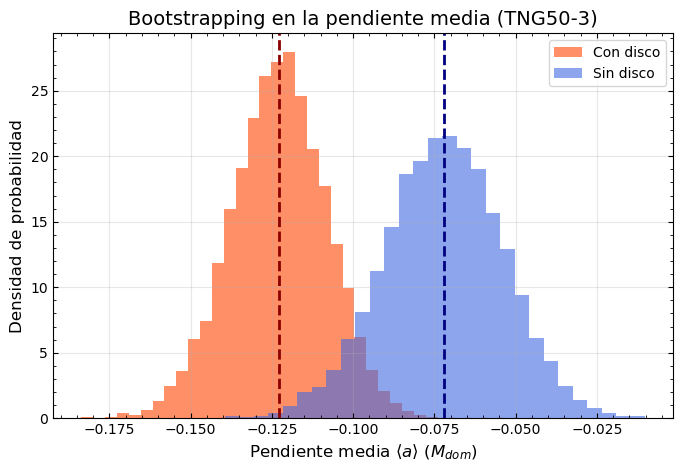

In [51]:
# Bootstrap robusto: Calculando pendientes individuales y luego bootstrapping de la media

# 1. Obtener la población de pendientes reales
pop_slopes_disk = get_slopes_for_halos(halos_disk)
pop_slopes_nodisk = get_slopes_for_halos(halos_nodisk)

print(f"Pendientes calculadas: {len(pop_slopes_disk)} (disco) vs {len(pop_slopes_nodisk)} (sin disco)")

# 2. Bootstrapping de la MEDIA de las pendientes
n_boot = 10000
boot_means_disk = []
boot_means_nodisk = []

np.random.seed(42)

for _ in range(n_boot):
    # Resamplear con reemplazo del conjunto de pendientes
    sample_disk = np.random.choice(pop_slopes_disk, size=len(pop_slopes_disk), replace=True)
    sample_nodisk = np.random.choice(pop_slopes_nodisk, size=len(pop_slopes_nodisk), replace=True)
    
    boot_means_disk.append(np.mean(sample_disk))
    boot_means_nodisk.append(np.mean(sample_nodisk))

boot_means_disk = np.array(boot_means_disk)
boot_means_nodisk = np.array(boot_means_nodisk)

# Probabilidad de que la pendiente media de disco sea menor (más negativa) que la de sin disco
prob_diff = np.mean(boot_means_disk < boot_means_nodisk)

print("\nResultados Bootstrap (Método de pendientes individuales):")
print(f"Pendiente media (Con disco): {np.mean(boot_means_disk):.4f} ± {np.std(boot_means_disk):.4f}")
print(f"Pendiente media (Sin disco): {np.mean(boot_means_nodisk):.4f} ± {np.std(boot_means_nodisk):.4f}")
print(f"Probabilidad (a_disk < a_nodisk): {prob_diff:.4f}")

# Graficar
plt.figure(figsize=(8, 5))
plt.hist(boot_means_disk, bins=30, alpha=0.6, color='orangered', density=True, label='Con disco')
plt.hist(boot_means_nodisk, bins=30, alpha=0.6, color='royalblue', density=True, label='Sin disco')
plt.axvline(np.mean(pop_slopes_disk), color='darkred', linestyle='--', lw=2)
plt.axvline(np.mean(pop_slopes_nodisk), color='navy', linestyle='--', lw=2)

plt.xlabel(r"Pendiente media $\langle a \rangle$ ($M_{dom}$)", fontsize=12)
plt.ylabel("Densidad de probabilidad", fontsize=12)
plt.title("Bootstrapping en la pendiente media (TNG50-3)", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.minorticks_on()
#mostrar los ticks de arriba y la derecha hacia adentro
plt.tick_params(axis='both', which='both', top=True, right=True, direction='in')
plt.savefig(results_path + 'Bootstrap_mean_slopes_Mdom_robust_T3.png', dpi=300, bbox_inches='tight')
plt.show()

Separando por aquellos con fracción de masa por encima de 0 en algun caso

Tipo 1:
log(Mdom/Mdom0) = (0.0331 ± 0.0087, rel 26.21%) * z + (-0.0269 ± 0.0188, rel 69.80%)
R² = 0.7443

Tipo 2:
log(Mdom/Mdom0) = (-0.1509 ± 0.0111, rel 7.33%) * z + (0.0620 ± 0.0239, rel 38.52%)
R² = 0.9739

Tipo 1:
log(Mdom/Mdom0) = (0.0620 ± 0.0118, rel 19.00%) * z + (0.0387 ± 0.0254, rel 65.76%)
R² = 0.8470

Tipo 2:
log(Mdom/Mdom0) = (-0.1150 ± 0.0177, rel 15.37%) * z + (0.0046 ± 0.0382, rel 823.33%)
R² = 0.8943



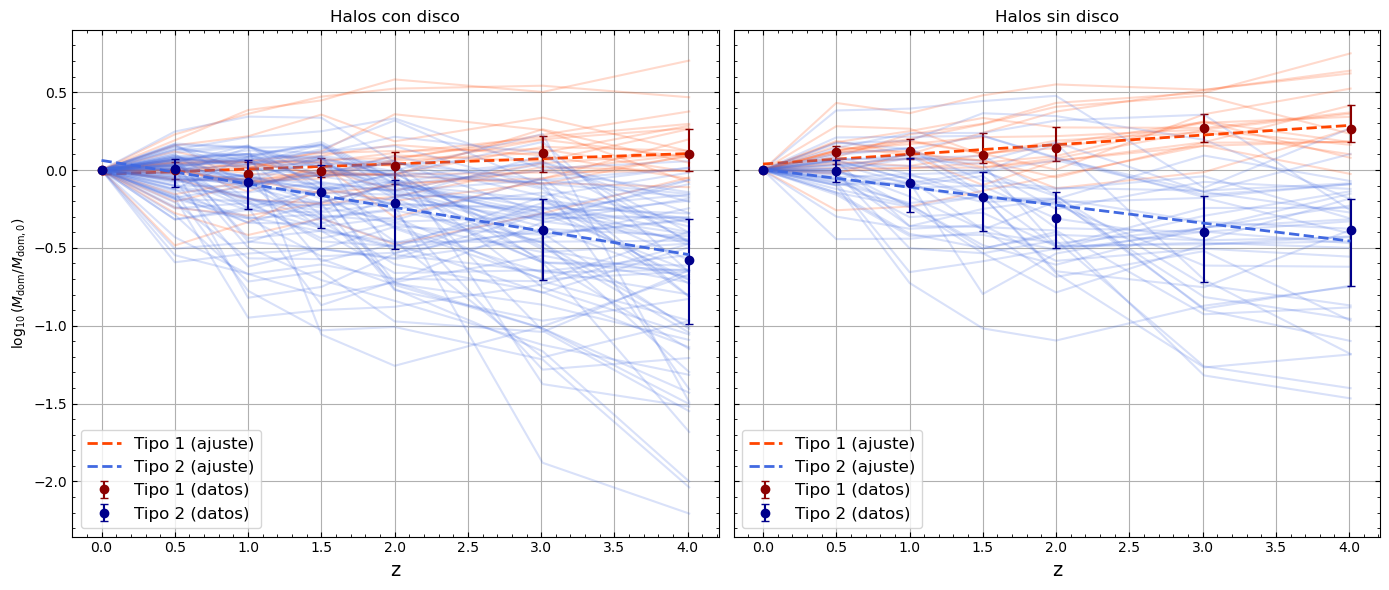

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_group_with_fit(axs[0], halos_Mdomup[halos_Mdomup['has_disk'] == 1], color='orangered', color2='darkred', label='Tipo 1', mass_type='Mdom')
plot_group_with_fit(axs[0], halos_Mdomdown[halos_Mdomdown['has_disk'] == 1], color='royalblue', color2='darkblue', label='Tipo 2', mass_type='Mdom')
axs[0].set_title('Halos con disco')

plot_group_with_fit(axs[1], halos_Mdomup[halos_Mdomup['has_disk'] == 0], color='orangered', color2='darkred', label='Tipo 1', mass_type='Mdom')
plot_group_with_fit(axs[1], halos_Mdomdown[halos_Mdomdown['has_disk'] == 0], color='royalblue', color2='darkblue', label='Tipo 2', mass_type='Mdom')
axs[1].set_title('Halos sin disco')

axs[0].set_ylabel(r"$\log_{10}(M_{\rm dom}/M_{\rm dom,0})$")
plt.tight_layout()
plt.show()

$M_{dom}(z)/M_{dom}(0) = a*z + b*ln(1+z)$ 

Con disco:
ln(Mdom/Mdom0) = -0.4109*z + 0.4276*ln(1+z)
R² = 0.9927

Sin disco:
ln(Mdom/Mdom0) = -0.2162*z + 0.2018*ln(1+z)
R² = 0.8302



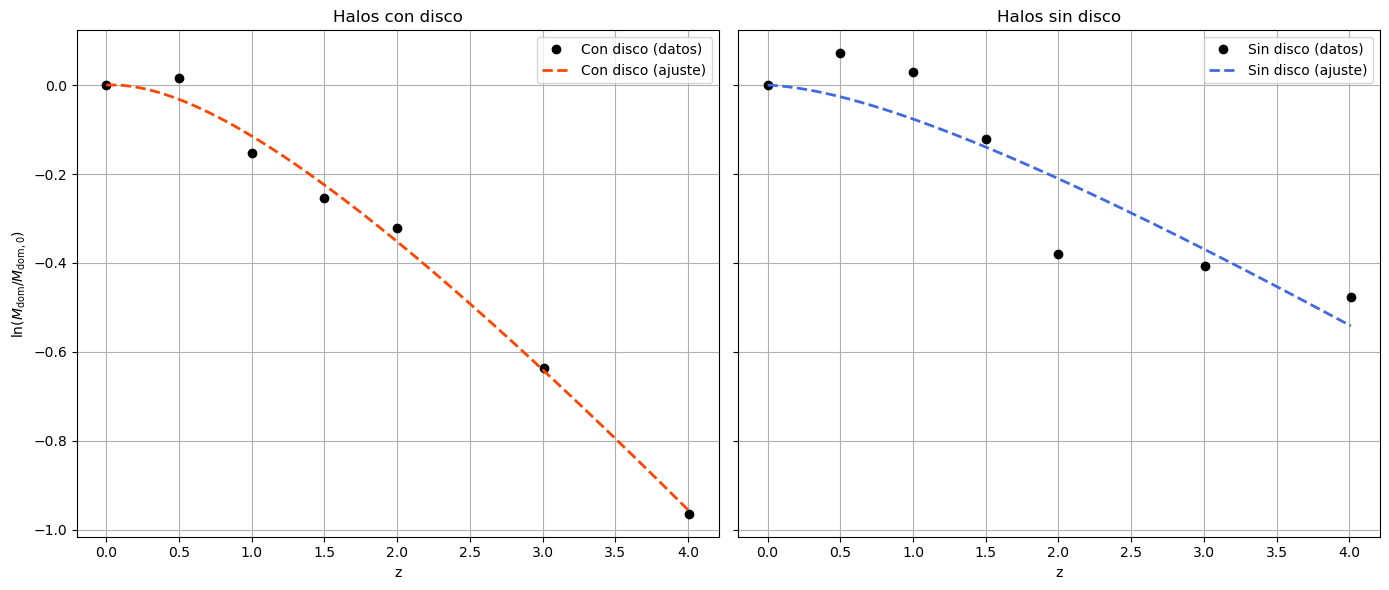

In [53]:
# Ajuste lineal a las curvas de Mdom/Mdom0 vs z en escala logarítmica

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

def other_fit(z, a, b):
    """Función: y = b*ln(1+z) + a*z"""
    return b*np.log(1+z) + a*z

def plot_group_with_fit(ax, halos, color, label):
    # Agrupar por z para obtener medianas
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(other_fit, z_vals, np.log(mdom_median))
    
    # Crear curva suave para el ajuste
    z_smooth = np.linspace(z_vals.min(), z_vals.max(), 200)
    fit_smooth = other_fit(z_smooth, *popt)
    
    # Graficar datos originales
    ax.plot(z_vals, np.log(mdom_median), 'o', color='k', label=f'{label} (datos)')
    
    # Graficar ajuste
    ax.plot(z_smooth, fit_smooth, '--', color=color, linewidth=2, 
            label=f'{label} (ajuste)')
    
    ax.set_xlabel("z")
    ax.grid(True)
    ax.legend()
    
    # Mostrar ecuación del ajuste
    print(f"{label}:")
    print(f"ln(Mdom/Mdom0) = {popt[0]:.4f}*z + {popt[1]:.4f}*ln(1+z)")
    print(f"R² = {1 - np.var(np.log(mdom_median) - other_fit(z_vals, *popt))/np.var(np.log(mdom_median)):.4f}")
    print()

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group_with_fit(axs[0], halos_disk, color='orangered', label='Con disco')
axs[0].set_title('Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group_with_fit(axs[1], halos_nodisk, color='royalblue', label='Sin disco')
axs[1].set_title('Halos sin disco')

axs[0].set_ylabel(r"$\ln(M_{\rm dom}/M_{\rm dom,0})$")
plt.tight_layout()
plt.show()

Mdom

In [54]:
def fit_group(halos):
    # Agrupar por z para obtener medianas
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mdom_median))
    perr = np.sqrt(np.diag(pcov))  # errores estándar
    
    return z_vals, np.log10(mdom_median), popt, perr

# Ajustar ambos grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

z_disk, y_disk, popt_disk, perr_disk = fit_group(halos_disk)
z_nodisk, y_nodisk, popt_nodisk, perr_nodisk = fit_group(halos_nodisk)

def test_param(param_name, val1, err1, val2, err2):
    """
    Prueba de hipótesis para comparar dos parámetros ajustados usando t-test.
    H0: val1 == val2
    H1: val1 != val2
    """
    diff = val1 - val2
    se = np.sqrt(err1**2 + err2**2)
    t_stat = diff / se
    
    # Grados de libertad (aproximación de Welch-Satterthwaite)
    # Para errores de ajuste, usamos una aproximación conservadora
    df = ((err1**2 + err2**2)**2) / (err1**4 + err2**4)
    
    # p-valor bilateral usando distribución t
    p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df))
    
    print(f"Prueba de hipótesis para {param_name}:")
    print(f"  {param_name}_disk = {val1:.4f} ± {err1:.4f}")
    print(f"  {param_name}_nodisk = {val2:.4f} ± {err2:.4f}")
    print(f"  Diferencia = {diff:.4f}")
    print(f"  Estadístico t = {t_stat:.3f}")
    print(f"  Grados de libertad ≈ {df:.1f}")
    print(f"  p-valor = {p_val:.4f}")
    
    if p_val < 0.05:
        print("  → Rechazamos H0: diferencia estadísticamente significativa (p < 0.05)")
    else:
        print("  → No rechazamos H0: no hay evidencia suficiente de diferencia (p ≥ 0.05)")
    print()

# Uso
test_param("a", popt_disk[0], perr_disk[0], popt_nodisk[0], perr_nodisk[0])

Prueba de hipótesis para a:
  a_disk = -0.1079 ± 0.0084
  a_nodisk = -0.0653 ± 0.0126
  Diferencia = -0.0425
  Estadístico t = -2.817
  Grados de libertad ≈ 1.7
  p-valor = 0.1235
  → No rechazamos H0: no hay evidencia suficiente de diferencia (p ≥ 0.05)



In [55]:
#USANDO EL AJUSTE LINEAL PARA Mdom/Mdom0

def fit_group(halos):
    # Agrupar por z para obtener medianas
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log(mdom_median))
    perr = np.sqrt(np.diag(pcov))  # errores estándar
    
    return z_vals, np.log(mdom_median), popt, perr

# Ajustar ambos grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

z_disk, y_disk, popt_disk, perr_disk = fit_group(halos_disk)
z_nodisk, y_nodisk, popt_nodisk, perr_nodisk = fit_group(halos_nodisk)

# Prueba de hipótesis
def test_param(param_name, val1, err1, val2, err2):
    # H0: val1 == val2
    # H1: val1 != val2
    diff = val1 - val2
    se = np.sqrt(err1**2 + err2**2)
    t_stat = diff / se
    p_val = 2*(1 - stats.norm.cdf(abs(t_stat)))
    print(f"Prueba de hipótesis para {param_name}:")
    print(f"{param_name}_disk = {val1:.4f} ± {err1:.4f}")
    print(f"{param_name}_nodisk = {val2:.4f} ± {err2:.4f}")
    print(f"Diferencia = {diff:.4f}  |  t = {t_stat:.3f}  |  p = {p_val:.4f}")
    if p_val < 0.05:
        print("Rechazamos H0: diferencia estadísticamente significativa.")
    else:
        print("No rechazamos H0: no hay evidencia suficiente de diferencia.")

# Probar a y b
test_param("a", popt_disk[0], perr_disk[0], popt_nodisk[0], perr_nodisk[0])

Prueba de hipótesis para a:
a_disk = -0.2484 ± 0.0193
a_nodisk = -0.1504 ± 0.0289
Diferencia = -0.0980  |  t = -2.817  |  p = 0.0048
Rechazamos H0: diferencia estadísticamente significativa.


Mvir

In [56]:
def fit_group(halos):
    # Agrupar por z para obtener medianas
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log(mvir_median))
    perr = np.sqrt(np.diag(pcov))  # errores estándar
    
    return z_vals, np.log(mvir_median), popt, perr

# Ajustar ambos grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

z_disk, y_disk, popt_disk, perr_disk = fit_group(halos_disk)
z_nodisk, y_nodisk, popt_nodisk, perr_nodisk = fit_group(halos_nodisk)

# --- Prueba de hipótesis ---
def test_param(param_name, val1, err1, val2, err2):
    diff = val1 - val2
    se = np.sqrt(err1**2 + err2**2)
    t_stat = diff / se
    p_val = 2*(1 - stats.norm.cdf(abs(t_stat)))
    print(f"Función Mvir/Mvir0 = az + b:")
    print(f"Prueba de hipotesis para {param_name}:")
    print(f"{param_name}_disk = {val1:.4f} ± {err1:.4f}")
    print(f"{param_name}_nodisk = {val2:.4f} ± {err2:.4f}")
    print(f"Diferencia = {diff:.4f}  |  t = {t_stat:.3f}  |  p = {p_val:.5f}")
    if p_val < 0.05:
        print("Rechazamos H0: diferencia estadísticamente significativa.")
    else:
        print("No rechazamos H0: no hay evidencia suficiente de diferencia.")

# Probar a y b
test_param("a", popt_disk[0], perr_disk[0], popt_nodisk[0], perr_nodisk[0])

Función Mvir/Mvir0 = az + b:
Prueba de hipotesis para a:
a_disk = -0.8446 ± 0.0076
a_nodisk = -0.7782 ± 0.0153
Diferencia = -0.0664  |  t = -3.883  |  p = 0.00010
Rechazamos H0: diferencia estadísticamente significativa.


### Bootstrapping

In [57]:
def fit_group(halos):
    """Hace el ajuste a la mediana y devuelve parámetros (a, b)."""
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m / row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    # ajuste a la curva
    popt, _ = curve_fit(other_fit, z_vals, np.log(mdom_median))
    return popt  # (a, b)

# Bootstrap
def bootstrap_params(halos, n_boot=500, seed=0):
    rng = np.random.default_rng(seed)
    a_vals, b_vals = [], []
    n = len(halos)
    for _ in range(n_boot):
        sample = halos.sample(n, replace=True, random_state=rng)
        try:
            a, b = fit_group(sample)
            a_vals.append(a)
            b_vals.append(b)
        except:
            continue
    return np.array(a_vals), np.array(b_vals)

# Separar grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

# Ejecutar bootstrap
a_disk, b_disk = bootstrap_params(halos_disk, n_boot=1000)
a_nodisk, b_nodisk = bootstrap_params(halos_nodisk, n_boot=1000)

# Comparación
diff_a = a_disk - a_nodisk[:, None]  # todas las diferencias posibles
p_value = (np.sum(diff_a < 0) / diff_a.size)  # probabilidad de que a_disk < a_nodisk

print(f"Media bootstrap a_disk = {np.mean(a_disk):.4f} ± {np.std(a_disk):.4f}")
print(f"Media bootstrap a_nodisk = {np.mean(a_nodisk):.4f} ± {np.std(a_nodisk):.4f}")
print(f"Probabilidad a_disk < a_nodisk = {p_value:.3f}")

Media bootstrap a_disk = -0.4055 ± 0.0893
Media bootstrap a_nodisk = -0.2264 ± 0.1122
Probabilidad a_disk < a_nodisk = 0.895


El análisis bootstrap sugiere que los halos con disco presentan una pendiente más negativa en su historia de acreción (a=−0.41) que los halos sin disco (a=−0.23), con una probabilidad del 89.5% de que esta diferencia sea real. Esto indica que, aunque la señal no alcanza el umbral clásico de significancia estadística, existe evidencia moderada de que la formación temprana de masa está asociada a la presencia de discos en las galaxias.

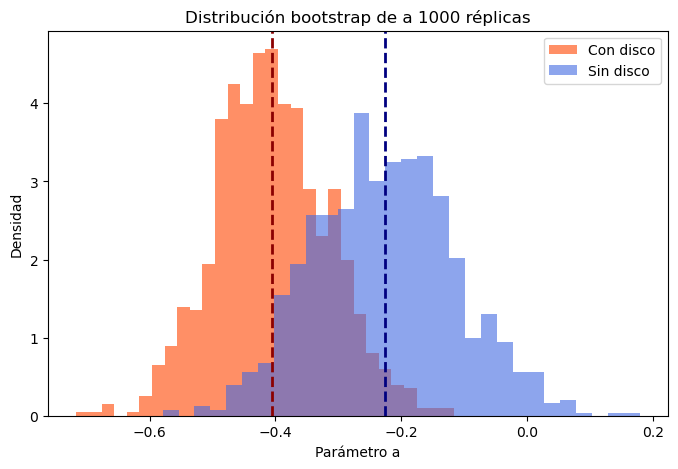

In [58]:
# Distribuciones de a
plt.figure(figsize=(8,5))
plt.hist(a_disk, bins=30, alpha=0.6, color="orangered", density=True, label="Con disco")
plt.hist(a_nodisk, bins=30, alpha=0.6, color="royalblue", density=True, label="Sin disco")
plt.axvline(np.mean(a_disk), color="darkred", linestyle="--", lw=2)
plt.axvline(np.mean(a_nodisk), color="navy", linestyle="--", lw=2)
plt.xlabel("Parámetro a")
plt.ylabel("Densidad")
plt.legend()
plt.title("Distribución bootstrap de a 1000 réplicas")
plt.savefig(results_path + 'bootstrap_a_disk_nodisk_T3.png', dpi=300, bbox_inches='tight')
plt.show()             

### Mvir/Mdom

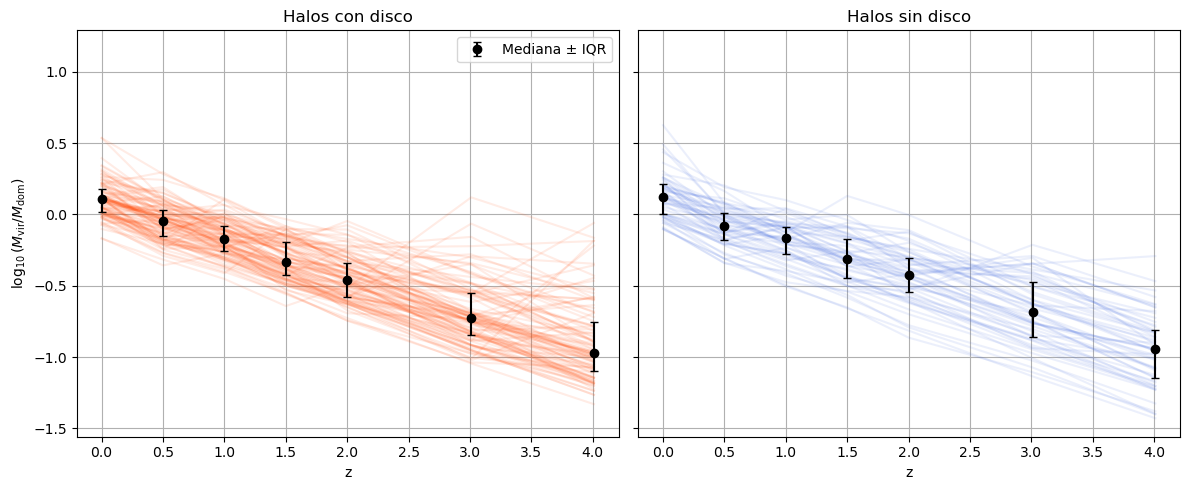

In [59]:
#mvir/mdom vs z con dispersión para halos con y sin disco

fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

def plot_group(ax, halos, color, title):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir_mdom = np.array(row['Mvir']/row['Mdom'])
        ax.plot(z, np.log10(mvir_mdom), color=color, alpha=0.1)

    # Agrupar por z
    mvir_mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']/row['Mdom']):
            if zz not in mvir_mdom_by_z:
                mvir_mdom_by_z[zz] = []
            mvir_mdom_by_z[zz].append(m)

    z_vals = np.array(sorted(mvir_mdom_by_z.keys()))
    mvir_mdom_median = np.array([np.median(mvir_mdom_by_z[zz]) for zz in z_vals])
    mvir_mdom_q25    = np.array([np.percentile(mvir_mdom_by_z[zz], 25) for zz in z_vals])
    mvir_mdom_q75    = np.array([np.percentile(mvir_mdom_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(z_vals, np.log10(mvir_mdom_median),
                yerr=[np.log10(mvir_mdom_median)-np.log10(mvir_mdom_q25),
                      np.log10(mvir_mdom_q75)-np.log10(mvir_mdom_median)],
                fmt='o', color='black', ecolor='black', capsize=3,
                label='Mediana ± IQR')

    ax.set_title(title)
    ax.set_xlabel("z")
    ax.grid(True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(axs[0], halos_disk, color='orangered', title='Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(axs[1], halos_nodisk, color='royalblue', title='Halos sin disco')

axs[0].set_ylabel(r"$\log_{10}(M_{\rm vir}/M_{\rm dom})$")
axs[0].legend()

plt.tight_layout()
plt.show()

# Tests estadisticos

In [60]:
# Exploremos la estructura de los datos
print("Estructura del DataFrame history_accretion:")
print(f"Número total de halos: {len(history_accretion)}")
print(f"Halos con disco: {len(history_accretion[history_accretion['has_disk'] == 1])}")
print(f"Halos sin disco: {len(history_accretion[history_accretion['has_disk'] == 0])}")
print("\nColumnas disponibles:")
print(history_accretion.columns.tolist())
print("\nEjemplo de datos de un halo:")
print(history_accretion.iloc[0])

Estructura del DataFrame history_accretion:
Número total de halos: 160
Halos con disco: 103
Halos sin disco: 57

Columnas disponibles:
['halo_id', 'snap', 'z', 'Mdom', 'Mvir', 'Rvir', 'Mvir_ratio', 'has_disk', 'Mdom/Mdom0']

Ejemplo de datos de un halo:
halo_id                                   [1, 1, 3, 2, 2, 0, 5]
snap                               [99, 67, 50, 40, 33, 25, 21]
z                         [0.0, 0.5, 1.0, 1.5, 2.0, 3.01, 4.01]
Mdom          [5440.24179314, 5054.11909167, 4266.42672636, ...
Mvir          [7462.92333984, 4386.95605469, 2615.14013672, ...
Rvir          [856.03497314, 809.35626221, 711.62109375, 661...
Mvir_ratio    [1.0, 0.587833460819665, 0.3504176604306466, 0...
has_disk                                                      1
Mdom/Mdom0    [0.0, -0.03197273136164369, -0.105553911219700...
Name: 0, dtype: object
